## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc
import seaborn as sns

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v9,\
                                                    align_features_and_labels_multi_test

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
sns.set_theme()
sns.set(rc={'figure.figsize':(10,10)})

from scipy.stats import kurtosis,skew,spearmanr,kendalltau

#print('hej')

2.2.0
C:\Users\PC\AppData\Local\Temp\tmpukygoo32\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ'
#     datafiles = os.listdir(path)
    datafiles = [re.split(' ',i)[0]+'.csv' if ' ' in i else i for i in os.listdir(path)]
#     print(datafiles)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]
        
        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec.csv
1: aggregateTAQ_May2020_30sec.csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


2


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


### Dropping ETFS and market indices

In [3]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [4]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [5]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [6]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker'],
      dtype='object')

In [8]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[429000 rows x 17 columns]

# Investigating return characteristics.

In [9]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

In [10]:
for i,ticker in enumerate(data.Ticker.unique()):
    
    ## Price series
    temp_price = data[data.Ticker==ticker].close
    
    ## Returns
    simple_ticker_returns = ((temp_price.values[1:]/temp_price.values[:-1]) - 1)
    log_ticker_returns = (np.log(temp_price.values[1:]) - np.log(temp_price.values[:-1]))
    log_abs_ticker_returns = np.abs(log_ticker_returns)
    
    ## Returns over x period 
    simple_ticker_returns_x = [((temp_price.values[i:]/temp_price.values[:-i]) - 1)*100 for i in [3,5,10]]
    log_ticker_returns_x = [(np.log(temp_price.values[i:]) - np.log(temp_price.values[:-i]))*100 for i in [3,5,10]]
    log_abs_ticker_returns_x = np.abs(log_ticker_returns_x)
    
    ##### Autocorrelations
    ## Pearsons
    autocorr_log = np.correlate(log_ticker_returns,
                                log_ticker_returns,
                                mode='full')
    autocorr_log = autocorr_log[autocorr_log.size//2:]
    if i == 0:
        print(log_ticker_returns,'\n\n',np.abs(log_ticker_returns))
    autocorr_log_abs = np.correlate(np.abs(log_ticker_returns),
                                np.abs(log_ticker_returns),
                                mode='full')
    autocorr_log_abs = autocorr_log_abs[autocorr_log_abs.size//2:]
    
    autocorr_simple = np.correlate(simple_ticker_returns,
                                   simple_ticker_returns,
                                   mode='full')
    autocorr_simple = autocorr_simple[autocorr_simple.size//2:]
    
    ## Spearmans
    s_auto_log,p_val_l = spearmanr(log_ticker_returns[0:-1],log_ticker_returns[1:])
    s_auto_log_abs,p_val_l_abs = spearmanr(np.abs(log_ticker_returns[0:-1]),np.abs(log_ticker_returns[1:]))
    s_auto_simple,p_val_s = spearmanr(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    ## Kendalls
    k_auto_log,pval_l = kendalltau(log_ticker_returns[0:-1],log_ticker_returns[1:])
    k_auto_log_abs,pval_l_abs = kendalltau(np.abs(log_ticker_returns[0:-1]),np.abs(log_ticker_returns[1:]))
    k_auto_simple,pval_s = kendalltau(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    if i == 0:
        simple_returns = pd.DataFrame()
        log_returns = pd.DataFrame()
        log_abs_returns = pd.DataFrame()
        
        additional_simple = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                                  'P_val_S','Corr_K','P_val_K',
                                                  'Avg spread','Med spread','Med Return',
                                                  'Med Return 3','Med Return 5','Med Return 10'])
        
        additional_log = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                               'P_val_S','Corr_K','P_val_K',
                                               'Avg spread','Med spread','Med Return',
                                               'Med Return 3','Med Return 5','Med Return 10'])
        
        additional_log_abs = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                               'P_val_S','Corr_K','P_val_K',
                                               'Avg spread','Med spread','Med Return'
                                                   ,'Med Return 3','Med Return 5','Med Return 10'])
        
        returns = pd.DataFrame({'simple_returns':simple_ticker_returns,
                                'log_returns':log_ticker_returns,
                                'log_abs_returns':log_abs_ticker_returns})
        returns['ticker'] = ticker
    else:
        temp = pd.DataFrame({'simple_returns':simple_ticker_returns,
                             'log_returns':log_ticker_returns,
                             'log_abs_returns':log_abs_ticker_returns})
        temp['ticker'] = ticker
        returns = pd.concat([returns,temp])
    
    simple_returns.loc[:,ticker] = simple_ticker_returns*100
    log_returns.loc[:,ticker] = log_ticker_returns*100
    log_abs_returns.loc[:,ticker] = log_abs_ticker_returns*100
    
    ## Spread as a percentage of the price
    spread_per_price = (data[data.Ticker==ticker].spread_close/temp_price)*100
    
    additional_simple.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                                  'P_val_S','Corr_K','P_val_K',
                                  'Avg spread','Med spread','Med Return',
                                  'Med Return 3','Med Return 5',
                                  'Med Return 10']] = [kurtosis(simple_ticker_returns),
                                                         skew(simple_ticker_returns),
                                                         autocorr_simple[0],
                                                         s_auto_simple,
                                                         p_val_s,
                                                         k_auto_simple,
                                                         pval_s,
                                                         np.mean(spread_per_price),
                                                        np.median(spread_per_price),
                                                       np.median(simple_ticker_returns),
                                                       np.median(simple_ticker_returns_x[0]),
                                                       np.median(simple_ticker_returns_x[1]),
                                                       np.median(simple_ticker_returns_x[2])]
    additional_log.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                               'P_val_S','Corr_K','P_val_K',
                               'Avg spread','Med spread','Med Return',
                               'Med Return 3','Med Return 5',
                               'Med Return 10']] = [kurtosis(log_ticker_returns),
                                                     skew(log_ticker_returns),
                                                     autocorr_log[0],
                                                      s_auto_log,
                                                      p_val_l,
                                                      k_auto_log,
                                                      pval_l,
                                                      np.mean(spread_per_price),
                                                     np.median(spread_per_price),
                                                    np.median(log_ticker_returns),
                                                    np.median(log_ticker_returns_x[0]),
                                                    np.median(log_ticker_returns_x[1]),
                                                    np.median(log_ticker_returns_x[2])]
    additional_log_abs.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                                   'P_val_S','Corr_K','P_val_K',
                                   'Avg spread','Med spread','Med Return',
                                   'Med Return 3','Med Return 5',
                                   'Med Return 10']] = [kurtosis(log_abs_ticker_returns),
                                                         skew(log_abs_ticker_returns),
                                                         autocorr_log_abs[0],
                                                          s_auto_log_abs,
                                                          p_val_l_abs,
                                                          k_auto_log_abs,
                                                          pval_l_abs,
                                                          np.mean(spread_per_price),
                                                         np.median(spread_per_price),
                                                        np.median(log_abs_ticker_returns),
                                                        np.median(log_abs_ticker_returns_x[0]),
                                                        np.median(log_abs_ticker_returns_x[1]),
                                                        np.median(log_abs_ticker_returns_x[2])]
#         simple_returns = (data.close.values[1:]/data.close.values[0:-1])-1
# log_returns = np.log(data.close.values[1:]) - np.log(data.close.values[0:-1])

[-0.00083005 -0.00152355  0.00178301 ...  0.00192698 -0.0024603
 -0.002372  ] 

 [0.00083005 0.00152355 0.00178301 ... 0.00192698 0.0024603  0.002372  ]


In [11]:
simple_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SO,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT
0,-0.082970,0.925812,0.000000,-0.121256,0.253273,1.274668,0.368770,0.137300,-0.298954,0.000000,...,-0.178747,0.090688,-0.065136,0.045204,-0.569393,0.210204,-0.459140,0.386743,0.220157,0.037179
1,-0.152239,-0.580969,-0.054813,-0.151754,0.680826,0.512440,-0.783820,-0.106642,0.214179,0.012825,...,0.000000,-0.292410,-0.179241,0.209489,0.137226,0.114416,0.349146,-0.026754,0.196850,0.276677
2,0.178460,0.196838,-0.005484,-0.705210,0.008506,-0.487467,0.987515,-0.099131,0.042744,0.089767,...,-0.671501,-0.636101,-0.228534,0.016396,0.732625,0.038095,-0.006384,-0.165917,0.199311,-0.078244
3,0.423736,0.116643,0.010969,-0.024490,-0.257283,-0.487608,-0.548299,0.104318,-0.064089,0.064061,...,-0.360555,-0.062355,-0.245419,-0.163934,0.820825,0.000000,0.114921,0.026805,0.130715,-0.020607
4,-0.080945,-0.055188,-0.071291,-0.097985,0.125775,-0.117419,-0.179092,-0.066084,-0.192390,0.064020,...,0.090465,-0.370201,-0.295227,-0.155993,-0.142718,-0.361767,-0.226389,-0.455569,0.190141,0.226720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.048551,0.357646,0.235433,0.157922,0.141352,0.109418,-0.078905,0.186468,-0.247372,0.106146,...,0.183534,0.162119,0.389421,0.067442,0.171642,-0.079106,-0.047024,0.034956,0.035731,0.121017
7795,-0.078347,0.210583,0.320290,0.029199,0.038672,0.020622,-0.030900,-0.099103,0.082662,-0.084827,...,0.000000,0.011843,0.032326,0.031716,-0.047929,-0.039584,-0.020583,0.004992,-0.096949,-0.084609
7796,0.192884,-0.070047,0.255414,-0.105085,0.071516,-0.059793,0.075557,0.120977,-0.123890,0.021225,...,-0.139580,-0.074998,-0.193892,-0.011890,-0.185816,0.079200,-0.029410,-0.029951,0.030645,0.274205
7797,-0.245727,0.124016,0.148612,-0.040909,-0.148723,0.010315,0.106387,0.007250,0.165392,0.021220,...,0.000000,0.027652,0.032378,-0.099092,0.154934,-0.178059,0.002942,-0.059919,0.000000,-0.209112


In [12]:
log_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SO,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT
0,-0.083005,0.921552,0.000000,-0.121330,0.252953,1.266613,0.368092,0.137206,-0.299401,0.000000,...,-0.178907,0.090647,-0.065157,0.045194,-0.571020,0.209984,-0.460197,0.385997,0.219915,0.037172
1,-0.152355,-0.582663,-0.054828,-0.151870,0.678518,0.511132,-0.786908,-0.106699,0.213950,0.012825,...,0.000000,-0.292838,-0.179401,0.209269,0.137132,0.114351,0.348538,-0.026757,0.196657,0.276295
2,0.178301,0.196645,-0.005484,-0.707708,0.008506,-0.488659,0.982671,-0.099180,0.042735,0.089726,...,-0.673766,-0.638133,-0.228796,0.016395,0.729954,0.038088,-0.006384,-0.166055,0.199113,-0.078275
3,0.422841,0.116575,0.010969,-0.024493,-0.257614,-0.488800,-0.549808,0.104263,-0.064109,0.064041,...,-0.361207,-0.062374,-0.245720,-0.164069,0.817474,0.000000,0.114855,0.026802,0.130630,-0.020609
4,-0.080978,-0.055203,-0.071317,-0.098033,0.125696,-0.117488,-0.179252,-0.066106,-0.192575,0.064000,...,0.090424,-0.370888,-0.295664,-0.156115,-0.142820,-0.362423,-0.226645,-0.456610,0.189961,0.226463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.048563,0.357008,0.235156,0.157798,0.141253,0.109358,-0.078936,0.186294,-0.247678,0.106090,...,0.183366,0.161988,0.388664,0.067419,0.171495,-0.079137,-0.047035,0.034950,0.035724,0.120943
7795,-0.078377,0.210362,0.319779,0.029195,0.038665,0.020620,-0.030905,-0.099152,0.082628,-0.084863,...,0.000000,0.011842,0.032321,0.031711,-0.047941,-0.039592,-0.020585,0.004992,-0.096996,-0.084645
7796,0.192698,-0.070071,0.255089,-0.105140,0.071490,-0.059810,0.075529,0.120904,-0.123967,0.021222,...,-0.139677,-0.075026,-0.194081,-0.011890,-0.185989,0.079169,-0.029414,-0.029955,0.030640,0.273829
7797,-0.246030,0.123939,0.148502,-0.040918,-0.148834,0.010315,0.106330,0.007250,0.165255,0.021218,...,0.000000,0.027648,0.032373,-0.099141,0.154815,-0.178218,0.002942,-0.059937,0.000000,-0.209331


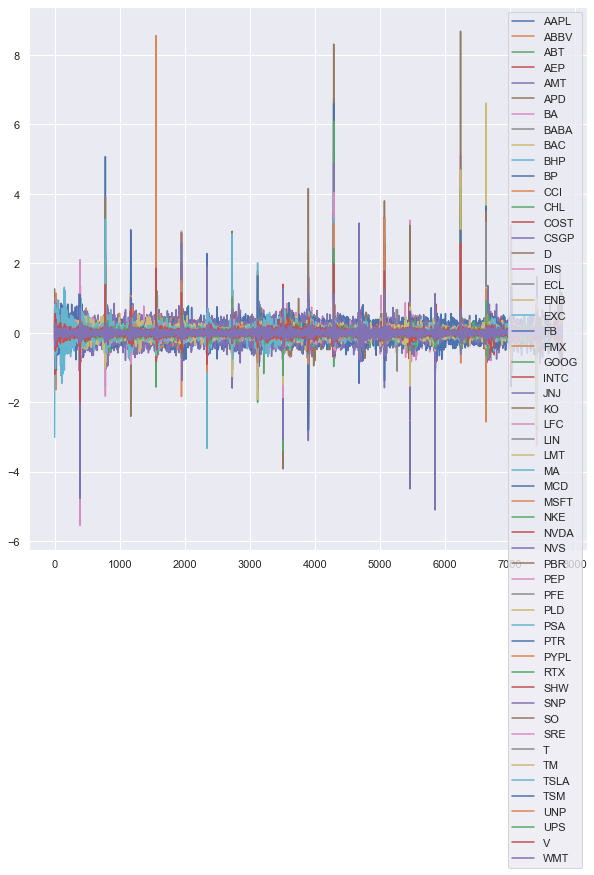

In [13]:
log_returns.plot(figsize=(10,10))
plt.show()

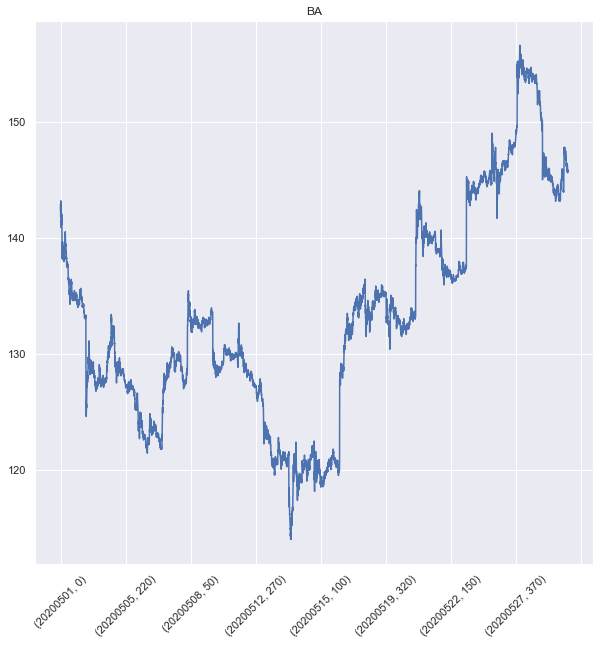

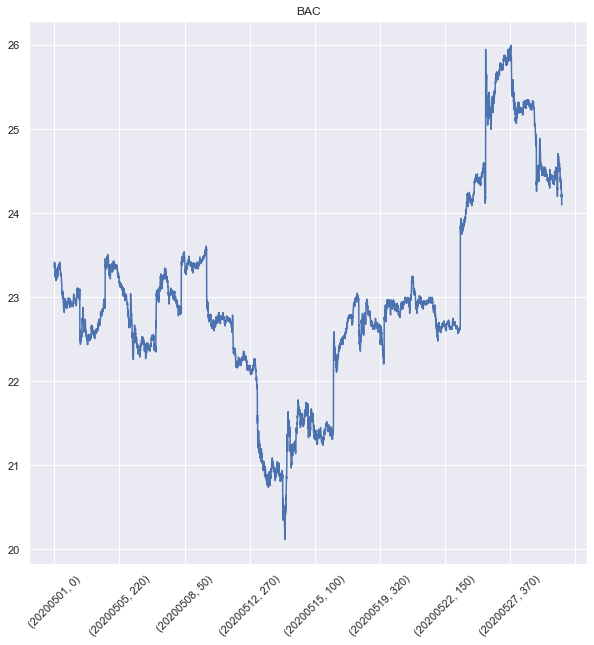

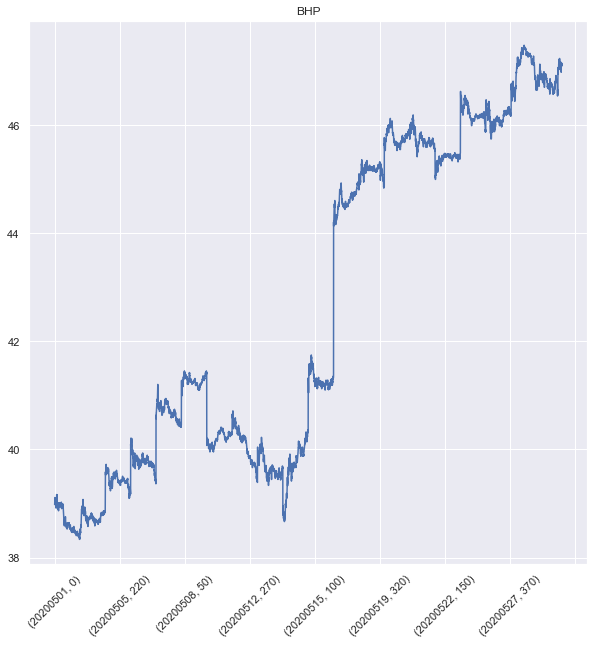

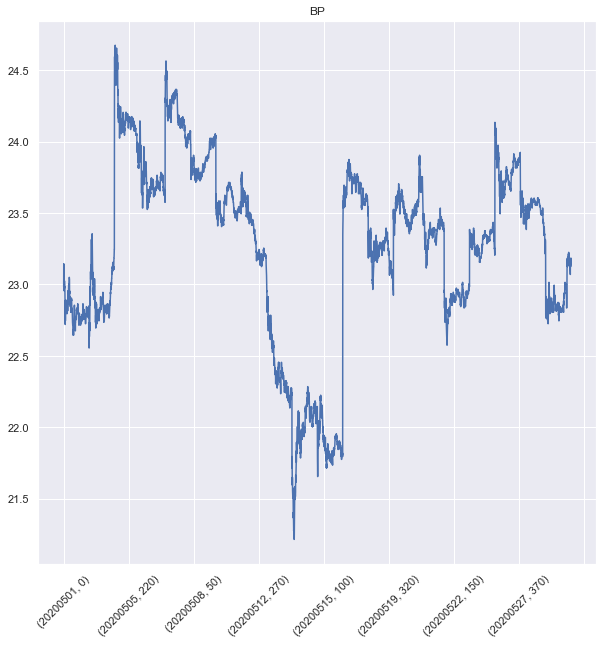

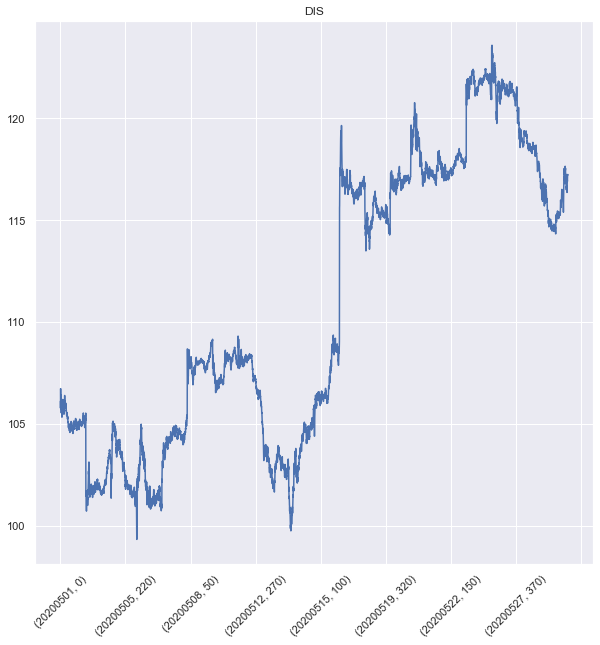

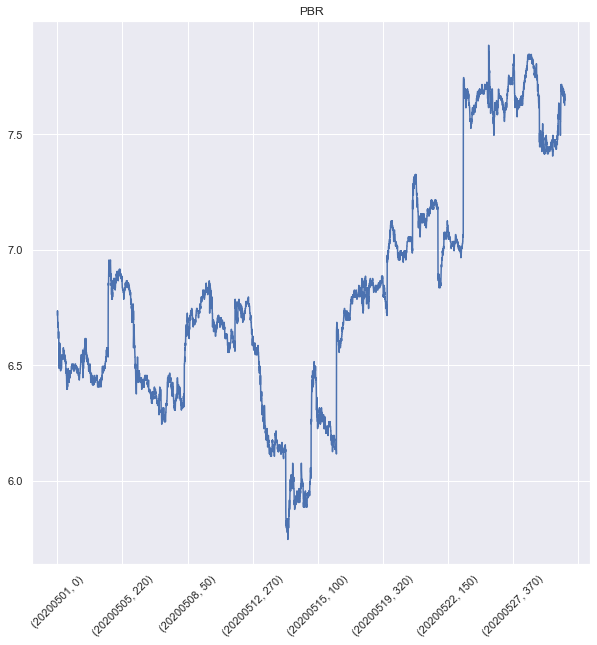

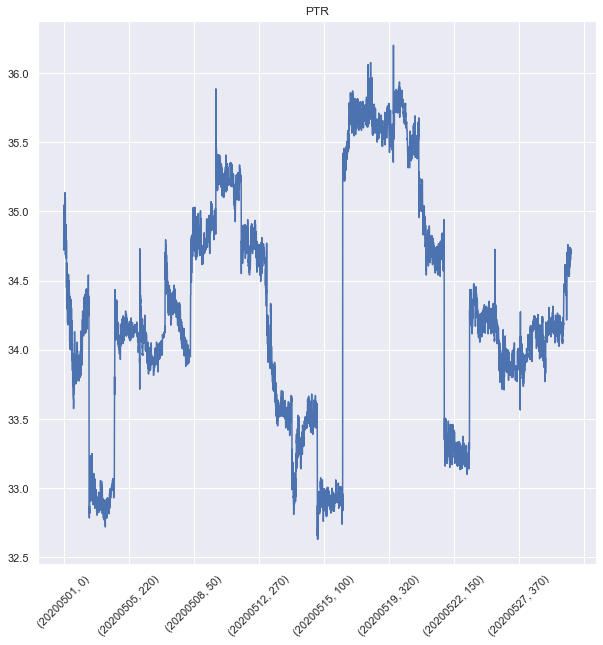

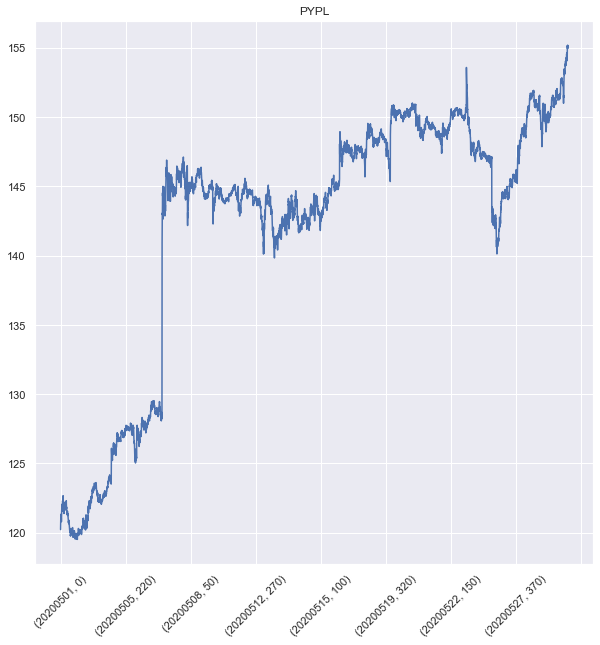

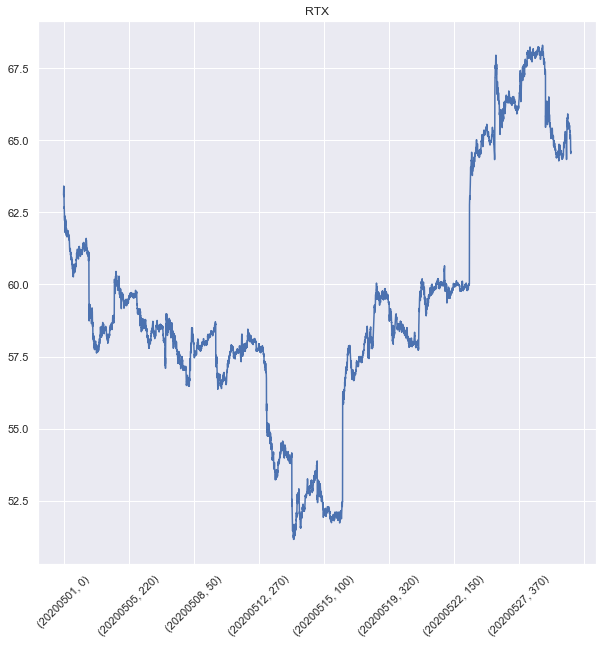

In [14]:
threshold = 5

for ticker in log_returns.columns:
    
    if log_returns[log_returns.loc[:,ticker]>threshold].shape[0]>0:
        data[data.Ticker==ticker].close.plot(figsize=(10,10))
        plt.xticks(rotation=45)
        plt.title(ticker)
        plt.show()

In [15]:
outliers = data[(data.Ticker=='BA')].close.values[1:][(log_returns.loc[:,'BA']>threshold)]
outliers

array([126.425, 144.675])

In [16]:
data[data.close.isin(outliers)]

open     high      low    close  spread_open  spread_high  \
20200505 355  126.465  126.515  126.370  126.425         0.05         0.06   
20200506 41   126.300  126.425  126.150  126.425         0.06         0.13   
20200507 18   126.050  126.425  126.020  126.425         0.08         0.36   
20200508 87   144.600  144.705  144.510  144.675         0.02         0.10   
20200512 359  126.535  126.615  126.405  126.425         0.05         0.21   
         153  144.760  144.820  144.595  144.675         0.02         0.08   
         175  144.705  144.735  144.660  144.675         0.05         0.06   
20200518 0    126.295  126.710  126.085  126.425         0.21         0.64   
20200519 378  126.355  126.590  126.275  126.425         0.09         0.25   
20200526 0    145.150  145.340  144.250  144.675         0.30         0.85   
         90   126.335  126.485  126.335  126.425         0.09         0.20   
20200527 72   144.930  145.305  144.630  144.675         0.06         0.57   
20200528 74   126.290  126.550  126.290  126.425         0.26         0.41   
         93   126.440  126.475  126.405  126.425         0.06         0.12   
         119  126.220  126.455  126.210  126.425         0.28         0.30   
20200529 40   126.445  126.445  126.300  126.425         0.31         0.38   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200505 355        0.01          0.03           4.0           5.0   
20200506 41         0.01          0.05           1.0           4.0   
20200507 18         0.01          0.05           1.0           6.0   
20200508 87         0.01          0.03           3.0           7.0   
20200512 359        0.01          0.13           2.0           5.0   
         153        0.01          0.03           1.0           5.0   
         175        0.01          0.03           2.0          11.0   
20200518 0          0.01          0.15           1.0           6.0   
20200519 378        0.03          0.17           1.0           4.0   
20200526 0          0.01          0.09           2.0          12.0   
         90         0.04          0.07           1.0           2.0   
20200527 72         0.01          0.21           1.0          13.0   
20200528 74         0.07          0.23           4.0           5.0   
         93         0.05          0.07           1.0           1.0   
         119        0.04          0.13           2.0           4.0   
20200529 40         0.07          0.31           1.0           1.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200505 355          1.0            1.0           5.0          11.0   
20200506 41           1.0            3.0           3.0           3.0   
20200507 18           1.0            2.0           1.0          10.0   
20200508 87           1.0            3.0           1.0           4.0   
20200512 359          1.0            1.0           1.0           4.0   
         153          1.0            2.0           1.0          10.0   
         175          1.0            7.0           5.0          10.0   
20200518 0            1.0            2.0          10.0          10.0   
20200519 378          1.0            2.0           1.0           4.0   
20200526 0            1.0            1.0           1.0          13.0   
         90           1.0            1.0           2.0           5.0   
20200527 72           1.0            3.0           6.0          13.0   
20200528 74           1.0            5.0           1.0           4.0   
         93           1.0            1.0           1.0           2.0   
         119          1.0            1.0           1.0           3.0   
20200529 40           1.0            1.0           1.0           4.0   

              ofrsize_low  ofrsize_close Ticker  
20200505 355          1.0            1.0   PYPL  
20200506 41           1.0            2.0   PYPL  
20200507 18           1.0            1.0     BA  
20200508 87           1.0            2.0   PYPL  
20200512 359          1.

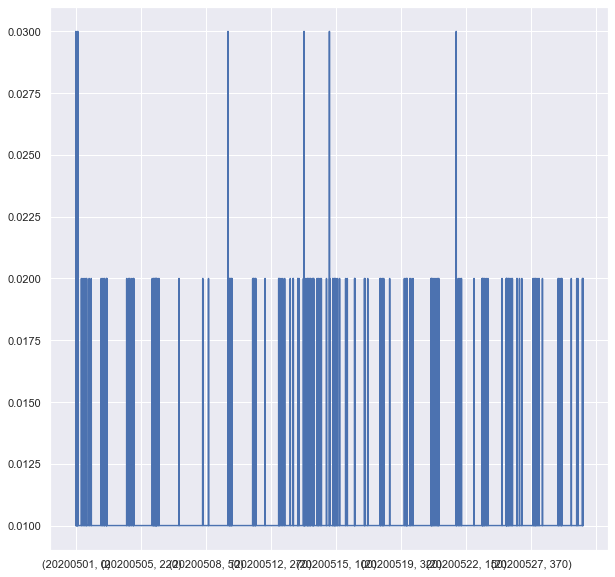

In [17]:
data[data.Ticker=='BP'].spread_close.plot(figsize=(10,10))
plt.show()

In [18]:
# pd.Series(simple_returns).describe()
simple_returns.describe().T.reset_index().merge(additional_simple.reset_index(),
                                                on = 'index',how='left')

,index,count,mean,std,min,25%,50%,75%,max,Kurt,...,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread,Med spread,Med Return,Med Return 3,Med Return 5,Med Return 10
0,AAPL,7799.0,0.001249,0.087208,-2.301282,-0.035355,0.001574,0.036999,1.684919,113.266,...,0.0288134,0.0109426,0.019875,0.00849631,0.0122323,0.0100287,1.57394e-05,0.00473119,0.0078509,0.0172831
1,ABBV,7799.0,0.001792,0.113296,-0.984750,-0.048595,0.000000,0.049429,2.798898,106.828,...,0.00774261,0.494214,0.00540149,0.474948,0.0307928,0.0230614,0,0,0.00541829,0.00552517
2,ABT,7799.0,0.000579,0.093585,-1.168100,-0.041795,0.000000,0.042524,2.275509,79.0232,...,-0.0111589,0.32449,-0.00814719,0.281396,0.0382299,0.03192,0,0,0,0.00531576
3,AEP,7799.0,0.000469,0.097286,-1.398560,-0.047092,0.000000,0.047206,1.528264,38.0447,...,-0.0316009,0.00525762,-0.0219616,0.00366706,0.0488495,0.0384098,0,0,0.00623869,0.00649435
4,AMT,7799.0,0.001369,0.111945,-1.051778,-0.047938,0.000000,0.050445,2.501651,76.5248,...,-0.0441443,9.63922e-05,-0.0304997,5.39062e-05,0.109325,0.0906093,0,0.00196052,0.00432975,0.00853953
5,APD,7799.0,0.001281,0.107650,-2.500750,-0.040481,0.000000,0.040590,3.193893,202.762,...,-0.0690271,1.04862e-09,-0.0479421,2.2287e-10,0.110128,0.0899119,0,0.00213666,0.00220736,0.0068045
6,BA,7799.0,0.000537,0.219623,-5.392635,-0.085961,0.000000,0.082295,5.262062,168.201,...,-0.00974499,0.389554,-0.00713182,0.345,0.0928512,0.0768581,0,-0.00393716,-0.00676155,-0.0146211
7,BABA,7799.0,0.000730,0.128049,-3.833730,-0.045212,0.000000,0.044466,3.694527,286.977,...,0.020226,0.0741022,0.0140673,0.0625584,0.0233133,0.0198103,0,0,0,0.00254865
8,BAC,7799.0,0.000510,0.170083,-2.348430,-0.045137,0.000000,0.044633,6.835495,491.907,...,-0.0148301,0.190381,-0.0111085,0.156944,0.043862,0.0437733,0,0,0,0
9,BHP,7799.0,0.002513,0.134259,-3.270577,-0.037703,0.000000,0.033009,6.864878,1018.35,...,0.0216882,0.0554765,0.0152777,0.0477398,0.026768,0.0245549,0,0,0,0


In [19]:
additional_log.columns

Index(['Kurt', 'Skew', 'Corr_P', 'Corr_S', 'P_val_S', 'Corr_K', 'P_val_K',
       'Avg spread', 'Med spread', 'Med Return', 'Med Return 3',
       'Med Return 5', 'Med Return 10'],
      dtype='object')

In [20]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[429000 rows x 17 columns]

In [21]:
#### Log returns

# stats = log_returns.describe().T.reset_index().merge(additional_log.reset_index(),
#                                                 on = 'index',how='left').astype({'count':int,
#                                                                                  'mean':float,
#                                                                                  'std':float,
#                                                                                  'min':float,
#                                                                                  '25%':float,
#                                                                                  '50%':float,
#                                                                                  '75%':float,
#                                                                                  'max':float,
#                                                                                  'Kurt':float,
#                                                                                  'Skew':float,
#                                                                                  'Corr_S':float,
#                                                                                  'Corr_K':float,
#                                                                                  'Corr_P':float,
#                                                                                  'P_val_S':float,
#                                                                                  'P_val_K':float,
#                                                                                  'Avg spread':float,
#                                                                                 'Med spread':float, 
#                                                                                  'Med Return 3':float,
#                                                                                  'Med Return 5':float,
#                                                                                  'Med Return 10':float}).\
#                                         round({'mean':5,'std':5,'min':5,
#                                                '25%':5,'50%':5,'75%':5,
#                                                'max':5,'Kurt':2,'Skew':2,
#                                                'Corr_P':5,'Corr_S':5,'P_val_S':5,
#                                                'Corr_K':5,'P_val_K':5,'Avg spread':3,
#                                                'Med spread':3,'Med Return 3':5,
#                                                'Med Return 5':5,'Med Return 10':5})

# #### Simple

stats = simple_returns.describe().T.reset_index().merge(additional_simple.reset_index(),
                                                on = 'index',how='left').astype({'count':int,
                                                                                 'mean':float,
                                                                                 'std':float,
                                                                                 'min':float,
                                                                                 '25%':float,
                                                                                 '50%':float,
                                                                                 '75%':float,
                                                                                 'max':float,
                                                                                 'Kurt':float,
                                                                                 'Skew':float,
                                                                                 'Corr_S':float,
                                                                                 'Corr_K':float,
                                                                                 'Corr_P':float,
                                                                                 'P_val_S':float,
                                                                                 'P_val_K':float,
                                                                                 'Avg spread':float,
                                                                                'Med spread':float,
                                                                                 'Med Return':float,
                                                                                 'Med Return 3':float,
                                                                                 'Med Return 5':float,
                                                                                 'Med Return 10':float}).\
                                        round({'mean':5,'std':5,'min':5,
                                               '25%':5,'50%':5,'75%':5,
                                               'max':5,'Kurt':2,'Skew':2,
                                               'Corr_P':5,'Corr_S':5,'P_val_S':5,
                                               'Corr_K':5,'P_val_K':5,'Avg spread':3,
                                               'Med spread':3,'Med Return 3':5,'Med Return':5,
                                               'Med Return 5':5,'Med Return 10':5})

#### Log Absolute

# stats = log_abs_returns.describe().T.reset_index().merge(additional_log_abs.reset_index(),
#                                                 on = 'index',how='left').astype({'count':int,
#                                                                                  'mean':float,
#                                                                                  'std':float,
#                                                                                  'min':float,
#                                                                                  '25%':float,
#                                                                                  '50%':float,
#                                                                                  '75%':float,
#                                                                                  'max':float,
#                                                                                  'Kurt':float,
#                                                                                  'Skew':float,
#                                                                                  'Corr_S':float,
#                                                                                  'Corr_K':float,
#                                                                                  'Corr_P':float,
#                                                                                  'P_val_S':float,
#                                                                                  'P_val_K':float,
#                                                                                  'Avg spread':float,
#                                                                                 'Med spread':float, 
#                                                                                  'Med Return 3':float,
#                                                                                  'Med Return 5':float,
#                                                                                  'Med Return 10':float}).\
#                                         round({'mean':5,'std':5,'min':5,
#                                                '25%':5,'50%':5,'75%':5,
#                                                'max':5,'Kurt':2,'Skew':2,
#                                                'Corr_P':5,'Corr_S':5,'P_val_S':5,
#                                                'Corr_K':5,'P_val_K':5,'Avg spread':3,
#                                                'Med spread':3,'Med Return 3':5,
#                                                'Med Return 5':5,'Med Return 10':5})

columnsToDisregard = ['count','25%','50%','75%']
disregard = ~stats.columns.isin(columnsToDisregard)
final_table = stats[stats.columns[disregard]].sort_values('Med spread',ascending=True).reset_index(drop=True)
tickers = final_table.head(5).append(final_table.tail(5)).rename(columns={'index':'ticker'}).ticker
final_table.head(5).append(final_table.tail(5))

,index,mean,std,min,max,Kurt,Skew,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread,Med spread,Med Return,Med Return 3,Med Return 5,Med Return 10
0,AAPL,0.00125,0.08721,-2.30128,1.68492,113.27,0.50,0.00593,0.02881,0.01094,0.01987,0.00850,0.012,0.010,0.00002,0.00473,0.00785,0.01728
1,MSFT,0.00055,0.07757,-0.93733,1.22313,26.30,0.88,0.00469,0.01934,0.08766,0.01314,0.08192,0.010,0.011,0.00000,0.00538,0.00555,0.00544
2,WMT,0.00033,0.08389,-0.75896,3.21166,301.71,8.66,0.00549,-0.00289,0.79836,-0.00150,0.84251,0.022,0.016,0.00000,-0.00391,0.00000,-0.00400
3,INTC,0.00091,0.10827,-2.56367,2.81328,154.73,2.24,0.00914,0.01778,0.11641,0.01242,0.10278,0.019,0.017,0.00000,0.00000,0.00000,0.00000
4,FB,0.00138,0.11167,-1.53383,3.38913,156.06,4.73,0.00973,0.03069,0.00673,0.02077,0.00596,0.018,0.017,0.00002,0.00468,0.00245,0.00933
50,TM,0.00055,0.14280,-2.67413,4.80078,203.55,4.53,0.01590,-0.22904,0.00000,-0.16153,0.00000,0.247,0.153,0.00000,0.00000,0.00000,0.00000
51,SHW,0.00158,0.12803,-1.46982,2.21838,47.80,1.85,0.01278,-0.17228,0.00000,-0.11863,0.00000,0.239,0.197,0.00000,0.00336,0.00435,0.01049
52,SNP,-0.00017,0.20668,-4.97162,5.00275,144.45,-1.65,0.03331,-0.29070,0.00000,-0.20688,0.00000,0.358,0.234,0.00000,0.00000,0.00000,0.00000
53,PTR,0.00027,0.23120,-3.74928,6.81578,120.28,2.75,0.04168,-0.26061,0.00000,-0.18937,0.00000,0.450,0.264,0.00000,0.00000,0.00000,0.00000
54,CSGP,0.00052,0.22500,-4.39362,2.29920,29.52,-0.84,0.03948,-0.19528,0.00000,-0.13532,0.00000,0.447,0.323,0.00000,0.00076,0.00228,0.00606


In [22]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[429000 rows x 17 columns]

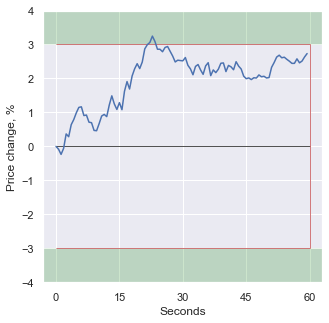

In [23]:
plt.figure(figsize=(5,5))
temp_data = data[data.Ticker=='AAPL'].iloc[0:100,3].reset_index(drop=True)
temp_series = ((temp_data/temp_data[0])-1)*100
plt.plot(temp_series)
plt.xticks(np.arange(0,125,25),np.arange(0,75,15))
plt.hlines(-3,0,100,color='r',linewidth = 0.75)
plt.hlines(0,0,100,linewidth = 0.75)
plt.hlines(3,0,100,color='r',linewidth = 0.75)
plt.vlines(100,-3,3,color='r',linewidth = 0.75)
plt.ylim(-4,4)
plt.axhspan(-3, -4, facecolor='green', alpha=0.2)
plt.axhspan(3, 4, facecolor='green', alpha=0.2)
plt.xlabel('Seconds')
plt.ylabel('Price change, %')
plt.show()
# plt.savefig('../../Figures_Thesis/price_path_1.png',dpi=400)

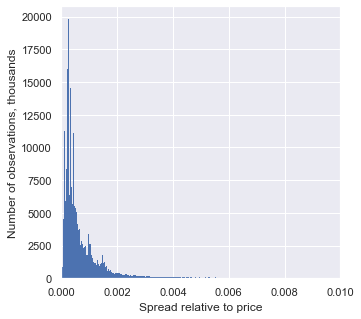

In [24]:
(data.spread_close/data.close).hist(bins='auto',figsize=(5,5),edgecolor='None')
plt.xlim(0,0.01)
plt.ylabel('Number of observations, thousands',fontsize=12)
# plt.yticks(np.arange(0,450000,50000),np.arange(0,450,50),fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.xlabel('Spread relative to price',fontsize=12)
plt.show()
# plt.savefig('../../Figures_Thesis/spread_full_v2.png',dpi=400)#,bboc_inches='tight'

In [25]:
(data.spread_close/data.close).quantile([0.5,
                                         0.6,
                                         0.7,
                                         0.8,
                                         0.9,
                                         0.95,
                                         0.99,
                                         0.995])

0.500    0.000422
0.600    0.000534
0.700    0.000743
0.800    0.001053
0.900    0.001647
0.950    0.002736
0.990    0.007746
0.995    0.009944
dtype: float64

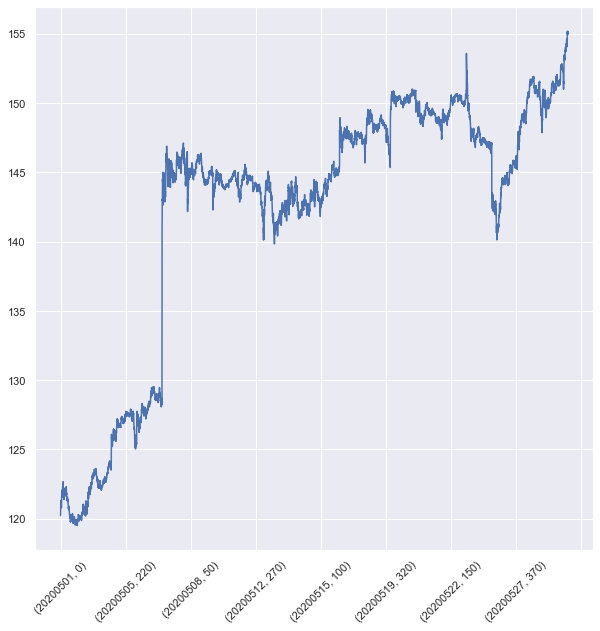

In [26]:
data[data.Ticker=='PYPL'].close.plot(figsize=(10,10))
plt.xticks(rotation=45)
plt.show()

# Effect of splits

In [27]:
## Add more tickers
#     temp = log_returns.loc[:,['AAPL','Day','Weekday','Hour category']]#,'MSFT','FB','PYPL','BA','PTR'
temp = simple_returns.copy(deep=True)#.loc[:,['AAPL','Day','Weekday','Hour category']]#,'MSFT','FB','PYPL','BA','PTR'
#     temp.loc[:,'Rolling_std'] = temp.AAPL.rolling(500).std()
## Rearange
#     temp = temp.loc[:,['Rolling_std','AAPL','Day','Weekday','Hour category']]
#     temp = temp.loc[:,['Rolling_std','AAPL','Day','Weekday','Hour category']]
var_to_plot = 'Rolling_std'
#     temp_long = pd.DataFrame(columns=['Rolling_std','date','ticker'])
temp_long = pd.DataFrame(columns=['return','ticker'])

for i in np.arange(temp.shape[1]-5):

#         t = pd.DataFrame({var_to_plot:temp.iloc[:,i],
#                     'date':temp.loc[:,'Day']})
    t = pd.DataFrame({'return':temp.iloc[:,i]})
    t.loc[:,'ticker'] = temp.columns[i]

    temp_long = pd.concat([temp_long,t])

## Adding splits
n_classes=3
_, splits = pd.qcut(temp_long.loc[:,'return'], q=n_classes, labels=False, retbins=True)

In [28]:
splits

array([-5.39263482, -0.02541081,  0.02574135,  9.07158044])

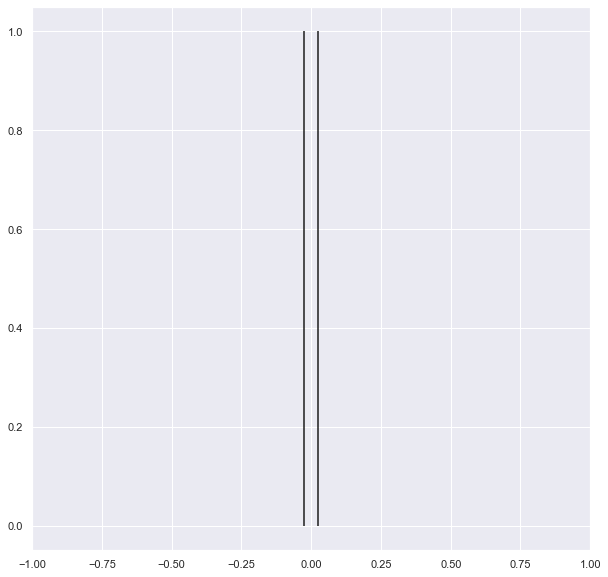

In [29]:
plt.plot()
plt.vlines(splits[1],0,1)
plt.vlines(splits[2],0,1)
plt.xlim(-1,1)
plt.show()

# Looking at the return distribution across time

In [65]:
# Weekdays
weekdays = {0: 'Monday'
             ,1:'Tuesday'
             ,2:'Wednesday'
             ,3:'Thursday'
             ,4:'Friday'}

# temp_return = log_returns.copy(deep=True)
log_returns.loc[:,'Day'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(0)
log_returns.loc[:,'Dt'] = pd.to_datetime(log_returns.Day,format='%Y%m%d')
log_returns.loc[:,'Weekday'] = log_returns.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
log_returns.loc[:,'Hour'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(1)
log_returns.loc[:,'Hour category'] = pd.cut(log_returns.Hour,
                                           bins=[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])

simple_returns.loc[:,'Day'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(0)
simple_returns.loc[:,'Dt'] = pd.to_datetime(log_returns.Day,format='%Y%m%d')
simple_returns.loc[:,'Weekday'] = log_returns.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
simple_returns.loc[:,'Hour'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(1)
simple_returns.loc[:,'Hour category'] = pd.cut(log_returns.Hour,
                                           bins=[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])

### Prepping to look at other metrics as well
data.loc[:,'Day'] = data.index.get_level_values(0)
data.loc[:,'Dt'] = pd.to_datetime(data.Day,format='%Y%m%d')
data.loc[:,'Weekday'] = data.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
data.loc[:,'Hour'] = data.index.get_level_values(1)
data.loc[:,'Hour category'] = pd.cut(data.Hour,
                                           bins=[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])


log_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,TSM,UNP,UPS,V,WMT,Day,Dt,Weekday,Hour,Hour category
0,-0.083005,0.921552,0.000000,-0.121330,0.252953,1.266613,0.368092,0.137206,-0.299401,0.000000,...,0.209984,-0.460197,0.385997,0.219915,0.037172,20200501,2020-05-01,Friday,1,09.30-10.30
1,-0.152355,-0.582663,-0.054828,-0.151870,0.678518,0.511132,-0.786908,-0.106699,0.213950,0.012825,...,0.114351,0.348538,-0.026757,0.196657,0.276295,20200501,2020-05-01,Friday,2,09.30-10.30
2,0.178301,0.196645,-0.005484,-0.707708,0.008506,-0.488659,0.982671,-0.099180,0.042735,0.089726,...,0.038088,-0.006384,-0.166055,0.199113,-0.078275,20200501,2020-05-01,Friday,3,09.30-10.30
3,0.422841,0.116575,0.010969,-0.024493,-0.257614,-0.488800,-0.549808,0.104263,-0.064109,0.064041,...,0.000000,0.114855,0.026802,0.130630,-0.020609,20200501,2020-05-01,Friday,4,09.30-10.30
4,-0.080978,-0.055203,-0.071317,-0.098033,0.125696,-0.117488,-0.179252,-0.066106,-0.192575,0.064000,...,-0.362423,-0.226645,-0.456610,0.189961,0.226463,20200501,2020-05-01,Friday,5,09.30-10.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.048563,0.357008,0.235156,0.157798,0.141253,0.109358,-0.078936,0.186294,-0.247678,0.106090,...,-0.079137,-0.047035,0.034950,0.035724,0.120943,20200529,2020-05-29,Friday,385,15.30-16.00
7795,-0.078377,0.210362,0.319779,0.029195,0.038665,0.020620,-0.030905,-0.099152,0.082628,-0.084863,...,-0.039592,-0.020585,0.004992,-0.096996,-0.084645,20200529,2020-05-29,Friday,386,15.30-16.00
7796,0.192698,-0.070071,0.255089,-0.105140,0.071490,-0.059810,0.075529,0.120904,-0.123967,0.021222,...,0.079169,-0.029414,-0.029955,0.030640,0.273829,20200529,2020-05-29,Friday,387,15.30-16.00
7797,-0.246030,0.123939,0.148502,-0.040918,-0.148834,0.010315,0.106330,0.007250,0.165255,0.021218,...,-0.178218,0.002942,-0.059937,0.000000,-0.209331,20200529,2020-05-29,Friday,388,15.30-16.00


In [66]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  ...  \
20200501 0          0.01          0.24           6.0          95.0  ...   
         1          0.01          0.10           9.0          20.0  ...   
         2          0.01          0.30           1.0          50.0  ...   
         3          0.01          0.17           1.0          25.0  ...   
         4          0.01          0.10          13.0          71.0  ...   
...                  ...           ...           ...           ...  ...   
20200529 385        0.01          0.04           1.0          11.0  ...   
         386        0.01          0.01           1.0           8.0  ...   
         387        0.01          0.05           4.0          16.0  ...   
         388        0.01          0.01           3.0           6.0  ...   
         389        0.01          0.21           1.0          20.0  ...   

              ofrsize_open  ofrsize_high  ofrsize_low  ofrsize_close  Ticker  \
20200501 0             1.0          85.0          1.0            4.0    AAPL   
         1             4.0          56.0          1.0            1.0    AAPL   
         2             1.0          13.0          1.0            1.0    AAPL   
         3             1.0           8.0          1.0            1.0    AAPL   
         4             1.0         236.0          1.0            1.0    AAPL   
...                    ...           ...          ...            ...     ...   
20200529 385           5.0           9.0          1.0            1.0     WMT   
         386           1.0           9.0          1.0            2.0     WMT   
         387           2.0          10.0          1.0            2.0     WMT   
         388           2.0          10.0          1.0            4.0     WMT   
         389           4.0          12.0          1.0            1.0     WMT   

                   Day         Dt  Weekday Hour Hour category  
20200501 0    20200501 2020-05-01   Friday    0   09.30-10.30  
         1    20200501 2020-05-01   Friday    1   09.30-10.30  
         2    20200501 2020-05-01   Friday    2   09.30-10.30  
         3    20200501 2020-05-01   Friday    3   09.30-10.30  
         4    20200501 2020-05-01   Friday    4   09.30-10.30  
...                ...        ...      ...  ...           ...  
20200529 385  20200529 2020-05-29   Friday  385   15.30-16.00  
         386  20200529 2020-05-29   Friday  386   15.30-16.00  
         387  20200529 2020-05-29   Friday  387   15.30-16.00  
         388  20200529 2020-05-29   Friday  388   15.30-16.00  
         389  20200529 2020-05-29   Friday  389   15.30-16.00  

[429000 rows x 22 columns]

In [67]:
pd.cut(log_returns.Hour,
       bins=[0,60,120,180,240,300,360,420],
       right=True,
       include_lowest=True,labels=['First hour',
                                   'Second hour',
                                   'Third hour',
                                   'Fourth hour',
                                   'Fifth hour',
                                   'Six hour',
                                   'Seventh hour']).loc[55:63]

pd.cut(log_returns.Hour,
       bins=[0,60,120,180,240,300,360,420],
       right=True,
       include_lowest=True,labels=['09.30-10.30',
                                   '10.30-11.30',
                                   '11.30-12.30',
                                   '12.30-13.30',
                                   '13.30-14.30',
                                   '14.30-15.30',
                                   '15.30-16.00']).loc[55:63]

55    09.30-10.30
56    09.30-10.30
57    09.30-10.30
58    09.30-10.30
59    09.30-10.30
60    10.30-11.30
61    10.30-11.30
62    10.30-11.30
63    10.30-11.30
Name: Hour, dtype: category
Categories (7, object): [09.30-10.30 < 10.30-11.30 < 11.30-12.30 < 12.30-13.30 < 13.30-14.30 < 14.30-15.30 < 15.30-16.00]

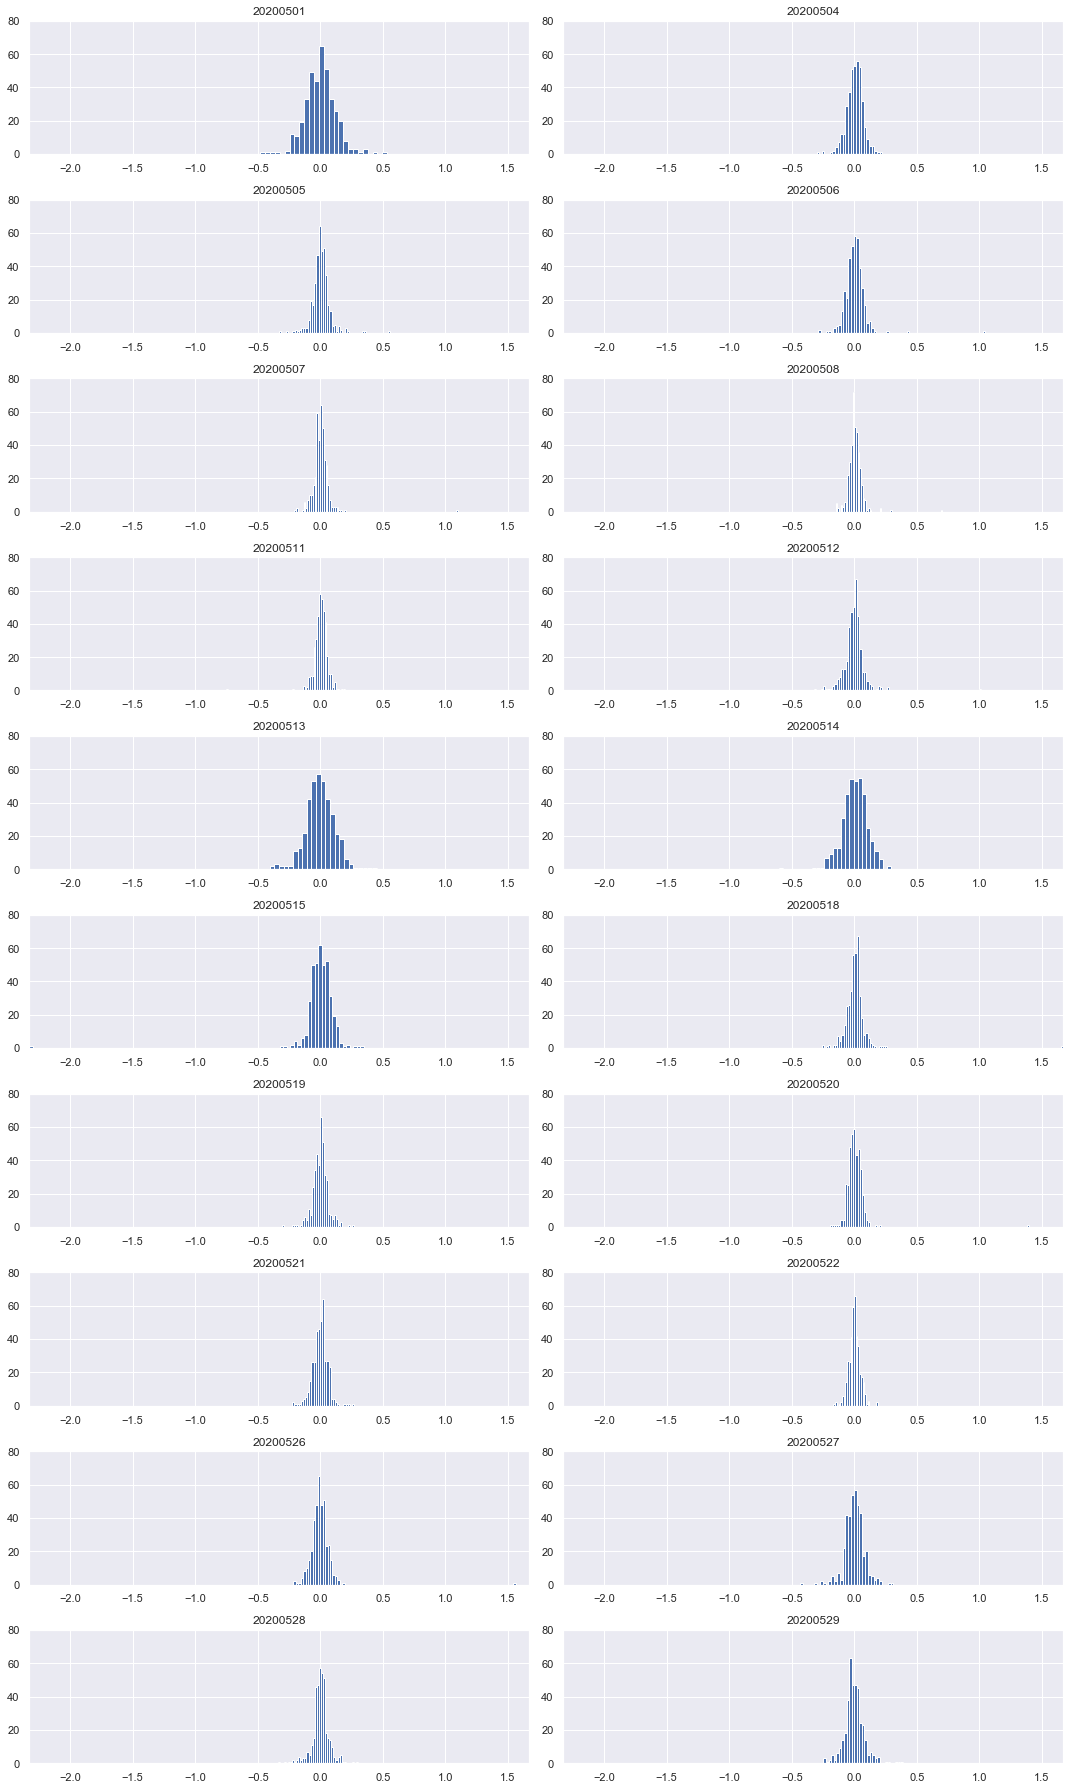

In [68]:
## Choose a ticker to show
ticker = 'AAPL'

## Getting the return and the days at which they occured.
temp = log_returns.loc[:,[ticker,'Day']]
# temp.loc[:,'Dt'] = pd.to_datetime(temp.Day,format='%Y%m%d')
# temp.loc[:,'Weekday'] = temp.Dt.dt.dayofweek.apply(lambda x: weekdays[x])


## Getting the unique days.
days = log_returns.Day.unique()

## Plotting the histogram of the returns for each day.
fig,ax = plt.subplots(10,2,figsize=(15,25))

l = 0

for i in np.arange(10):
    for j in np.arange(2):
#         print(temp[temp.Day==days[l]][ticker].astype(float).values.round(4))
#         ax[i,j].hist(temp[temp.Day==days[l]][ticker].values,bins='40')
        ax[i,j].hist(temp[temp.Day==days[l]][ticker].values,bins='auto')
        ax[i,j].set_title(days[l],fontsize=12)
        ax[i,j].set_xlim(temp[ticker].min(),temp[ticker].max())
#         ax[i,j].set_xlim(-0.5,0.5)
        ax[i,j].set_ylim(0,80)
        l += 1

fig.tight_layout(pad = 1)
plt.show()

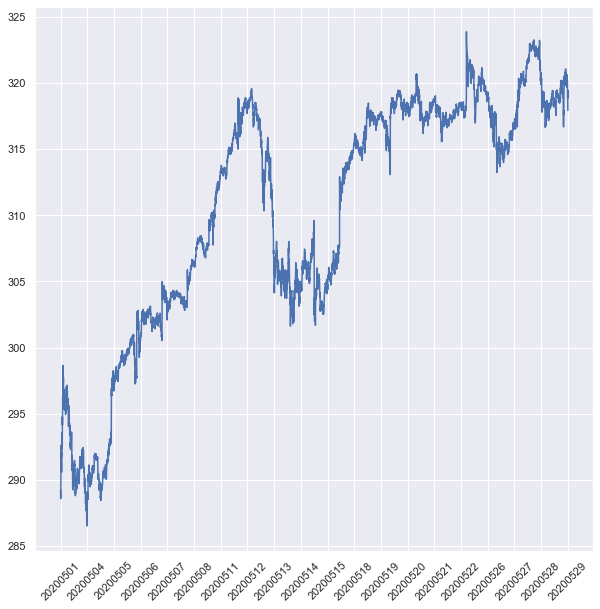

In [69]:
price_serie = data[data.Ticker == ticker].copy(deep=True).reset_index().loc[:,['level_0','close']]
price_serie.loc[:,'date'] = pd.to_datetime(price_serie.level_0,format='%Y%m%d')

plt.figure(figsize=(10,10))

### price_serie.plot(x='date',y='close')

# plt.plot(price_serie[price_serie.level_0==20200522].close.values)
plt.plot(price_serie.close.values)
plt.xticks(np.linspace(0,
                       len(price_serie.close),
                       len(price_serie.date.unique())),
           price_serie.level_0.unique(),rotation=45)
plt.show()

# Vol plot

In [70]:
temp = simple_returns.loc[:,['PYPL','Day','Weekday','Hour category']]#,'MSFT','FB','PYPL','BA','PTR'
temp.loc[:,'Rolling_std'] = temp.PYPL.rolling(120).std()
t = temp.Rolling_std.values[~np.isnan(temp.Rolling_std.values)]
tt = temp[~np.isnan(temp.Rolling_std.values)].Day

In [71]:
np.unique(tt)[0:5]

array([20200501, 20200504, 20200505, 20200506, 20200507], dtype=int64)

In [72]:
labels = np.unique(tt)[0:20][np.linspace(0,len(np.unique(tt)[0:20])-1,6).round(0).astype(int)]
labels = [str(i) for i in labels]

In [73]:
labels

['20200501', '20200507', '20200513', '20200518', '20200522', '20200529']

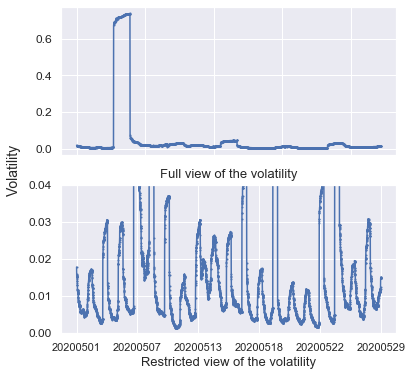

In [74]:
fig,ax = plt.subplots(2,1,figsize=(6,6))
# plt.setp(ax, 
#          np.linspace(0,len(tt),6).round(0).astype(int), 
#          xticklabels=labels)
# plt.figure(figsize=(8,5))
ax[0].plot(t[tt.isin(labels)]**2,marker='.',markersize = 2)

# ax[0].set_xticks(np.linspace(0,len(tt),6).round(0).astype(int))
ax[0].set_xticklabels([])
ax[0].set_xlabel('Full view of the volatility',fontsize=13)
ax[0].set_ylabel('Volatility',fontsize = 14)
ax[0].yaxis.set_label_coords(-0.12,-0.1)
# ax[0].set_yticklabels(fontsize=12)
ax[0].tick_params(axis="y", labelsize=12) 

ax[1].plot(t**2,marker='.',markersize = 2)
ax[1].set_ylim(0,0.04)
ax[1].set_xticks(np.linspace(0,len(tt),6).round(0).astype(int))
ax[1].set_xticklabels(labels,fontsize=11)
ax[1].set_xlabel('Restricted view of the volatility',fontsize=13)
ax[1].tick_params(axis="y", labelsize=12) 
# plt.xticks(np.arange(len(t)),temp.Day[~np.isnan(temp.Rolling_std.values)])
# plt.locator_params(axis="x", nbins=4)

# plt.xticks(np.linspace(0,len(tt),6).round(0).astype(int),
#            labels)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=30)
plt.show()
# plt.savefig('../../Figures_Thesis/vol_plot_v3.png',dpi=800)#,bboc_inches='tight'

ValueError: Could not interpret value `ticker` for parameter `hue`

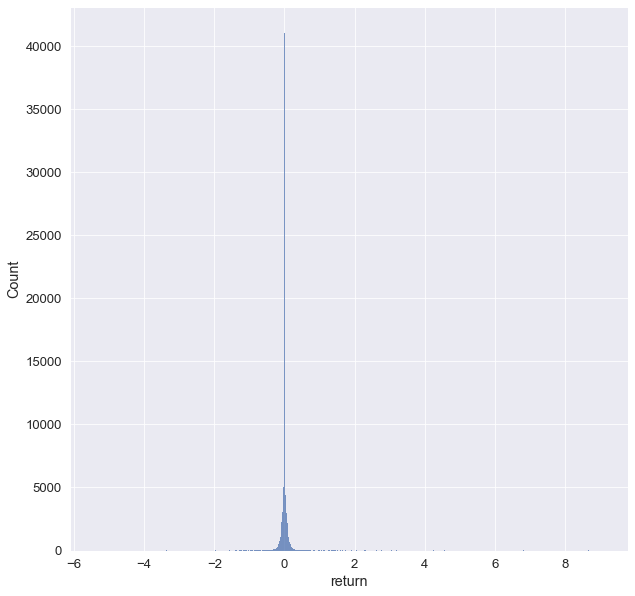

In [87]:
# fig,ax = plt.subplots(figsize=(10,10))
# sns.color_palette("viridis", as_cmap=True)
plot_multiple_tickers = True

sns.set_context("paper", font_scale=1.5)

if plot_multiple_tickers:
    
    ## Add more tickers
#     temp = log_returns.loc[:,['AAPL','Day','Weekday','Hour category']]#,'MSFT','FB','PYPL','BA','PTR'
    temp = simple_returns.copy(deep=True)#.loc[:,['AAPL','Day','Weekday','Hour category']]#,'MSFT','FB','PYPL','BA','PTR'
#     temp.loc[:,'Rolling_std'] = temp.AAPL.rolling(500).std()
    ## Rearange
#     temp = temp.loc[:,['Rolling_std','AAPL','Day','Weekday','Hour category']]
#     temp = temp.loc[:,['Rolling_std','AAPL','Day','Weekday','Hour category']]
    var_to_plot = 'Rolling_std'
#     temp_long = pd.DataFrame(columns=['Rolling_std','date','ticker'])
    temp_long = pd.DataFrame(columns=['return','ticker'])
    
    for i in np.arange(temp.shape[1]-5):
        
#         t = pd.DataFrame({var_to_plot:temp.iloc[:,i],
#                     'date':temp.loc[:,'Day']})
        t = pd.DataFrame({'return':temp.iloc[:,i]})
        t.loc[:,'ticker'] = temp.columns[i]
        
        temp_long = pd.concat([temp_long,t])
    
    ## Adding splits
    n_classes=3
    _, splits = pd.qcut(temp_long.loc[:,'return'], q=n_classes, labels=False, retbins=True)
    
    plot_to_save_0 = sns.histplot(temp_long,
                x='return',
#                 row='ticker',
#                 hue='ticker',
#                  kind='kde',
#                 height=6,
#                 palette = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),#sns.dark_palette("lightblue", reverse=True, as_cmap=True),#'dark:salmon_r',
#                 aspect = 4/4
                                 )#.set_axis_labels('Returns','Density')\
                #.set(xlim=(-1,1))
    
    plot_to_save= sns.kdeplot(temp_long[temp_long.ticker.isin(tickers)],
                x='return',
#                 row='ticker',
                hue='ticker',
#                  kind='kde',
                height=6,
#                 palette = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),#sns.dark_palette("lightblue", reverse=True, as_cmap=True),#'dark:salmon_r',
                aspect = 4/4,
                              ax=plot_to_save_0).set_axis_labels('Returns','Density')\
                .set(xlim=(-1,1))
    if n_classes == 3:
        plt.axvline(splits[1], 0,1,c='black',linestyle='--')
        plt.axvline(splits[2], 0,1,c='black',linestyle='--')
    
    elif n_classes == 5:
        plt.axvline(splits[1], 0,1,c='black',linestyle='--')
        plt.axvline(splits[2], 0,1,c='black',linestyle='--')
        plt.axvline(splits[3], 0,1,c='black',linestyle='--')
        plt.axvline(splits[4], 0,1,c='black',linestyle='--')
    
    
else:

    sns.displot(temp,
        x=ticker,
        hue='Day',
         kind='kde',
        height=10,
        palette = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),#sns.dark_palette("lightblue", reverse=True, as_cmap=True),#'dark:salmon_r',
        aspect = 12/10).set_axis_labels('Returns','Density').set(xlim=(-1,1))
        
# plt.show()
plot_to_save
# plot_to_save.savefig('../../Figures_Thesis/price_categories_5.png',dpi=800)#,bboc_inches='tight'

In [ ]:
t = temp.Rolling_std.values[~np.isnan(temp.Rolling_std.values)]

In [172]:
plt.figure(figsize=(8,5))
plt.plot(t**2,marker='.',markersize = 2)
plt.xticks(np.linspace(0,
                       len(t),
                       len(np.unique(t))),
           np.unique(t),
           rotation=45)
# plt.xticks(np.arange(len(t)),temp.Day[~np.isnan(temp.Rolling_std.values)])
# plt.locator_params(axis="x", nbins=4)
plt.show()

KeyboardInterrupt: 

In [76]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'Day', 'Dt', 'Weekday',
       'Hour', 'Hour category'],
      dtype='object')

In [77]:
data.loc[:,'spread_rel_price'] = data.spread_close / data.close

In [78]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  ...  \
20200501 0          0.01          0.24           6.0          95.0  ...   
         1          0.01          0.10           9.0          20.0  ...   
         2          0.01          0.30           1.0          50.0  ...   
         3          0.01          0.17           1.0          25.0  ...   
         4          0.01          0.10          13.0          71.0  ...   
...                  ...           ...           ...           ...  ...   
20200529 385        0.01          0.04           1.0          11.0  ...   
         386        0.01          0.01           1.0           8.0  ...   
         387        0.01          0.05           4.0          16.0  ...   
         388        0.01          0.01           3.0           6.0  ...   
         389        0.01          0.21           1.0          20.0  ...   

              ofrsize_high  ofrsize_low  ofrsize_close  Ticker       Day  \
20200501 0            85.0          1.0            4.0    AAPL  20200501   
         1            56.0          1.0            1.0    AAPL  20200501   
         2            13.0          1.0            1.0    AAPL  20200501   
         3             8.0          1.0            1.0    AAPL  20200501   
         4           236.0          1.0            1.0    AAPL  20200501   
...                    ...          ...            ...     ...       ...   
20200529 385           9.0          1.0            1.0     WMT  20200529   
         386           9.0          1.0            2.0     WMT  20200529   
         387          10.0          1.0            2.0     WMT  20200529   
         388          10.0          1.0            4.0     WMT  20200529   
         389          12.0          1.0            1.0     WMT  20200529   

                     Dt Weekday  Hour Hour category spread_rel_price  
20200501 0   2020-05-01  Friday     0   09.30-10.30         0.000830  
         1   2020-05-01  Friday     1   09.30-10.30         0.000346  
         2   2020-05-01  Friday     2   09.30-10.30         0.001040  
         3   2020-05-01  Friday     3   09.30-10.30         0.000588  
         4   2020-05-01  Friday     4   09.30-10.30         0.000344  
...                 ...     ...   ...           ...              ...  
20200529 385 2020-05-29  Friday   385   15.30-16.00         0.000322  
         386 2020-05-29  Friday   386   15.30-16.00         0.000081  
         387 2020-05-29  Friday   387   15.30-16.00         0.000402  
         388 2020-05-29  Friday   388   15.30-16.00         0.000081  
         389 2020-05-29  Friday   389   15.30-16.00         0.001696  

[429000 rows x 23 columns]

In [79]:
height = 5
width = 5
## Return distribution
# sns.displot(temp,
#             x=ticker,
#             col='Weekday',
#             col_wrap=3,
#             height=height,
#             aspect = width/height)

## Other metric
sns.displot(data,#ticker#[data.Ticker=='PTR']
            x='',
            col='Weekday',
            col_wrap=3,
            height=height,
            aspect = width/height,edgecolor='none')


plt.show()

ValueError: Could not interpret value `` for parameter `x`

In [80]:
height = 5
width = 5
### Return distribution
# sns.displot(temp,
#             x=ticker,
#             col='Hour category',
#             col_wrap=3,
#             height=height,
#             aspect = width/height)

### Other metric
sns.displot(data,#ticker[data.Ticker==ticker]
            x='spread_rel_price'#'spread_close',
            col='Hour category',
            col_wrap=3,
            height=height,
            aspect = width/height)

plt.show()

SyntaxError: invalid syntax (<ipython-input-80-a7b3eedf6b24>, line 14)

In [35]:
log_returns.columns

Index(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC', 'BHP',
       'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL', 'ENB', 'EXC',
       'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC', 'LIN', 'LMT', 'MA',
       'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA',
       'PTR', 'PYPL', 'RTX', 'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA',
       'TSM', 'UNP', 'UPS', 'V', 'WMT', 'Day', 'Dt', 'Weekday', 'Hour',
       'Hour category'],
      dtype='object')

In [36]:
# correlations = pd.DataFrame()

# for col in log_returns.columns:
        
#     autocorr_log_abs = np.correlate(log_returns.loc[:,col].abs()/100,
#                                     log_returns.loc[:,col].abs()/100,
#                                     mode='full')
#     autocorr_log_abs = autocorr_log_abs[autocorr_log_abs.size//2:]
    
#     correlations.loc[:,col] = autocorr_log_abs

In [37]:
# correlations

In [38]:
# def align_features_and_labels_multi_test(price_candles,
#                                             all_features,
#                                             prediction_horizon,
#                                             n_feature_lags,
#                                             n_classes,
#                                             label_split = [],
#                                             safe_burn_in = False,
#                                             data_sample = 'full',
#                                             splitType='global',
#                                             noise = False,
#                                             ticker_dummies = False,
#                                             top=None):

#     all_burned_in_features = pd.DataFrame()
#     all_burned_in_indices = pd.DataFrame()
#     all_labels = pd.DataFrame()

#     # dailyIndices = pd.DataFrame({'days':all_features.index.get_level_values(0),
#     #                               'timestamps':all_features.index.get_level_values(1),
#     #                               'ticker':all_features.ticker})
#     dailyIndices = all_features['ticker'].reset_index().rename(columns={'level_0':'days','level_1':'timestamps'}).copy(deep=True)

#     if splitType.lower() == 'global':
#         # Making the splits for the labels based on all tickers
#         # returns = ((price_candles['close'].values[1:] / price_candles['close'].values[:-1]) -1) * 100
# #         returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
# #                          price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
# #                           in price_candles.Ticker.unique()])

#         returns = []
#         tickers = []
#         end_point_cut = max(prediction_horizon, n_feature_lags + 1)
#         for ticker in all_features.ticker.unique():
#             temp_price = all_features[all_features.ticker==ticker].iloc[0:-n_feature_lags,:].close_lag0

#             ticker_returns = (temp_price.values[1:]/temp_price.values[:-1]) - 1
#             ticker_names = [ticker for i in range(len(ticker_returns))]

#             returns.append(ticker_returns)
#             tickers.append(ticker_names)

#         # concatenate returns and add noise
#         returns = np.concatenate(returns)
#         if noise:
#             returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

#         tickers = np.concatenate(tickers)

#         if label_split == []:
#             # equal-sized bins according to n_classes
#             if top is not None:
#                 test = copy.deepcopy(returns)
#                 print('upper limit: %.3f\nlower limit: %.3f' % (np.percentile(test,top),np.percentile(test,100-top)))
#                 test[test>np.percentile(test,top)] = np.percentile(test,top)
#                 test[test<np.percentile(test,100-top)] = np.percentile(test,100-top)
                
#                 _, splits = pd.qcut(test, q=n_classes, labels=False, retbins=True)
#                 print(splits)
#             else:
#                 _, splits = pd.qcut(returns, q=n_classes, labels=False, retbins=True)
#         elif label_split != []:
#             _, splits = pd.qcut(returns, q=label_split, labels=False, retbins=True)

#         #print(splits)

#         returns = pd.DataFrame({'returns': returns, 'ticker': tickers})

#     keepCheck = []

#     for ticker_iter, ticker_name in enumerate(all_features.ticker.unique()):
#         ticker_features = all_features[all_features.ticker==ticker_name].copy(deep=True)
#         ticker_indices = dailyIndices[dailyIndices.ticker==ticker_name].copy(deep=True)
#         # removing the "ticker" variable from ticker_features as np.isnan() does not like non-numericals
#         #ticker_features = ticker_features.iloc[:, ticker_features.columns != 'ticker']
#         ticker_features.drop('ticker', axis=1, inplace=True)
#         # extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
#         #ticker_prices = price_candles[price_candles.Ticker==ticker_name]['close'].values # candles.iloc[:, :4].values
# #         ticker_returns = returns[returns.ticker==ticker_name]['returns'].values
#         ticker_returns = test[returns.ticker==ticker_name]

#         if not safe_burn_in:
#             assert data_sample == 'full'
#             # we assume data_sample is full and that we can continue features from yesterday's values.
#             # that we have a single burn-in at the beginning and that's it

#             # get first index that has no NaNs (the sum checks for True across columns, we look for sum == 0 and where that is first True)
#             burned_in_idx = np.where((np.sum(np.isnan(ticker_features.values), axis=1) == 0) == True)[0][0]
#             if ticker_name == 'AAPL':
#                 print(burned_in_idx)
#             keepCheck.append(burned_in_idx)
#             # calculate end-point cut-off to match with labels
#             # end_point_cut = max(prediction_horizon, n_feature_lags + 1)

#             # slice away the observations used for burn-in (taking off 1 at the end to match with labels [slice off "prediction_horizon"])
#             burned_in_features = ticker_features.iloc[burned_in_idx : -end_point_cut, :].copy(deep=True) #.reset_index(drop=True) # features[burned_in_idx:] latter is sligthly faster but maybe not as precise
#             burned_in_indices = ticker_indices.iloc[burned_in_idx : -end_point_cut, :].copy(deep=True)
#             if ticker_name == 'AAPL':
#                 print(ticker_indices.iloc[burned_in_idx : -end_point_cut, :])
#             # slice away the burned-in indices from labels
#             labels = extract_labels_multi_test(data = ticker_returns[(burned_in_idx):],#+n_feature_lags
#                                                 classes = n_classes,
#                                                 splits = splits,top=top)
#             if ticker_name == 'AAPL':
#                 print(burned_in_features.shape,burned_in_indices.shape,labels.shape)
#             # labels, returns, thresholds = extract_labels(data = candles[burned_in_idx + n_feature_lags : , :],
#             #                                             classes = n_classes, group_style = 'equal')

#             # check if there are remaining NaNs are burn-in (means error)
#             remaining_nans = np.where(np.isnan(burned_in_features.values))[0].size
#             if remaining_nans > 0:
#                 raise ValueError('Had NaN in burned_in_features after burn-in')

#         # Adding the ticker
#         burned_in_features.loc[:,'ticker'] = ticker_name
#         if ticker_name == 'AAPL':
#             print(burned_in_indices.iloc[0:10,:])

#         # Adding the burned in data
#         all_burned_in_features = pd.concat([all_burned_in_features, burned_in_features.reset_index(drop=True)])
#         all_burned_in_indices = pd.concat([all_burned_in_indices, burned_in_indices.reset_index(drop=True)])#

#         if ticker_name == 'AAPL':
#             print(all_burned_in_indices.iloc[0:10,:])

#         all_labels = pd.concat([all_labels, pd.Series(labels)])
#         print(ticker_name + " done")

#     # Returning the ticker as dummies
#     if ticker_dummies:

#         tickers = all_burned_in_features.pop('ticker')
#         all_burned_in_features = pd.concat([all_burned_in_features, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

#     return all_burned_in_features.reset_index(drop=True),\
#             all_labels.reset_index(drop=True),\
#             all_burned_in_indices.reset_index(drop=True)

# def extract_labels_multi_test(data = None,
#                             classes = 5,
#                             splits=None,top=None):

#     # this version takes data in a direct returns for a specific ticker
#     # per version 6 we no longer use group_style, as the "splits" fully describes splits for both equal and non-equal
#     if top is not None:
#         labels = pd.cut(data, bins=splits, labels=False, right=False, include_lowest=True)
#     else:
#         labels = pd.cut(data, bins=splits, labels=False, right=False, include_lowest=True)

#     # we need right=False (open right-handside in split interval) to get median into the positive class
#     # this makes the last point nan, we fix it here
#     if sum(np.isnan(labels)) > 0:
#         print(f'Number of NaNs in label: {sum(np.isnan(labels))}. 1 is expected')
#         print(f'Returns that lead to NaNs in label: {data[np.where(np.isnan(labels))]}')
#         assert sum(np.isnan(labels)) <= 1, "There should be max 1 NaN"

#         if data[np.where(np.isnan(labels))] >= splits[-1]:
#             labels[np.where(np.isnan(labels))] = classes - 1 # assign last label id
        
#         elif data[np.where(np.isnan(labels))] <= splits[0]:
#             labels[np.where(np.isnan(labels))] = 0 # assign first label id
            
#         else:
#             print(data[np.where(np.isnan(labels))], splits[-1])
#             raise ValueError('There is a label NaN where its underlying return is not max of dataset, which it should be')

#     return labels

In [39]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
# #                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                       'macd_diff',
#                                                       'macd_signal',
#                                                     'dis5',
#                                                     'dis10',
#                                                       'sector'
                                                    'pastreturns',
                                                    'intradaytime'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 3
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
# X, y,indices = align_features_and_labels_multi_test(price_candles = price_candles, 
#                                                  all_features = features,
#                                                  prediction_horizon = 1, 
#                                                  n_feature_lags = n_feature_lags, 
#                                                  n_classes = n_classes, # 5,
#                                                  safe_burn_in = False, 
#                                                  data_sample = 'full',
#                                                  splitType='global',
#                                                  noise=False,
#                                                  ticker_dummies=False,top = 99.999)
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,
                                                 ticker_dummies=False)

0
            days  timestamps ticker
0     20200501.0         1.0   AAPL
1     20200501.0         2.0   AAPL
2     20200501.0         3.0   AAPL
3     20200501.0         4.0   AAPL
4     20200501.0         5.0   AAPL
...          ...         ...    ...
7793  20200529.0       384.0   AAPL
7794  20200529.0       385.0   AAPL
7795  20200529.0       386.0   AAPL
7796  20200529.0       387.0   AAPL
7797  20200529.0       388.0   AAPL

[7798 rows x 3 columns]
(7798, 36) (7798, 3) (7798,)
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0         4.0   AAPL
4  20200501.0         5.0   AAPL
5  20200501.0         6.0   AAPL
6  20200501.0         7.0   AAPL
7  20200501.0         8.0   AAPL
8  20200501.0         9.0   AAPL
9  20200501.0        10.0   AAPL
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0    

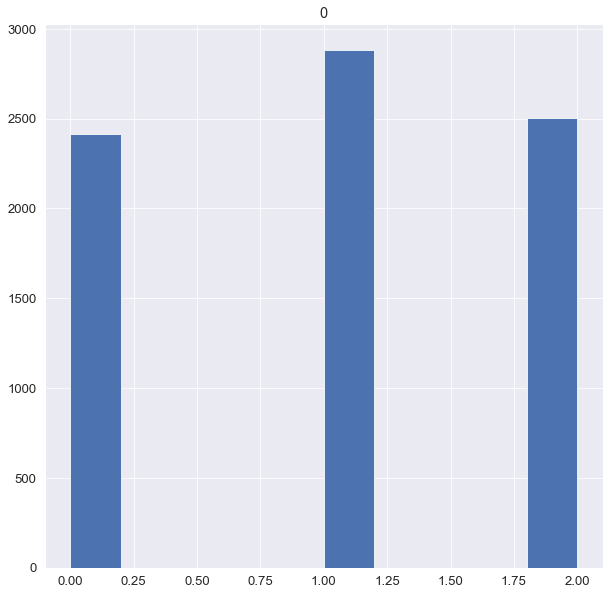

In [40]:
y[X.ticker=='AAPL'].hist()
plt.show()

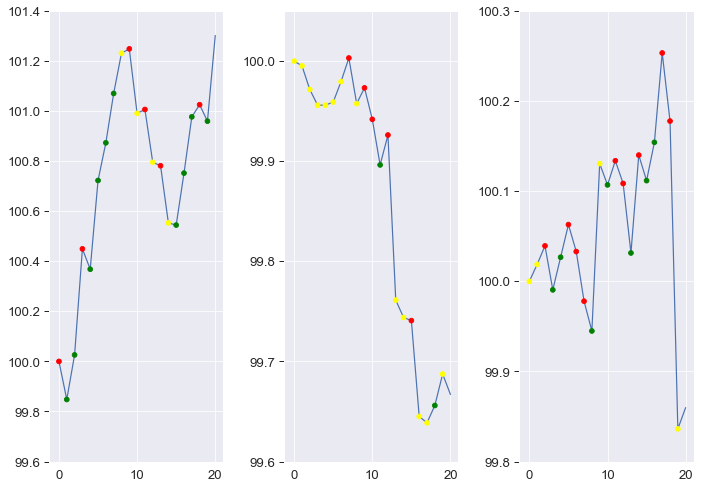

In [41]:
ticker = 'AAPL'

number_of_periods = 20

step_to_plot = [0,3000,7000]

colors = {0:'red',1:'yellow',2:'green'}

fig,ax = plt.subplots(1,
                      len(step_to_plot),
                      figsize = (10,7))

for i,stp in enumerate(step_to_plot):
    
    ## Preparing the series
    
    serie = X[X.ticker == ticker].loc[stp:stp+number_of_periods,'close_lag0'].copy(deep=True)
    series_indexed = (serie.values/serie.values[0])*100
    
    ## Plotting the price series
    
    ax[i].plot(series_indexed)
    ax2 = ax[i].twinx()
    
    ## Adding the labels

    ax2.scatter(x = X[X.ticker=='AAPL'].index[:number_of_periods],
                y=series_indexed[:-1],
               c=y[X.ticker=='AAPL'].loc[stp:stp+number_of_periods-1,0].astype(int)\
                                         .apply(lambda x: colors[x]))
    ## Formatting the axis

    pos = ax[i].get_yticks()
    ax[i].set_ylim(pos[0],pos[-1])
    ax2.set_ylim(pos[0],pos[-1])
    ax2.set_yticks([])


fig.tight_layout(pad = 1)
plt.show()

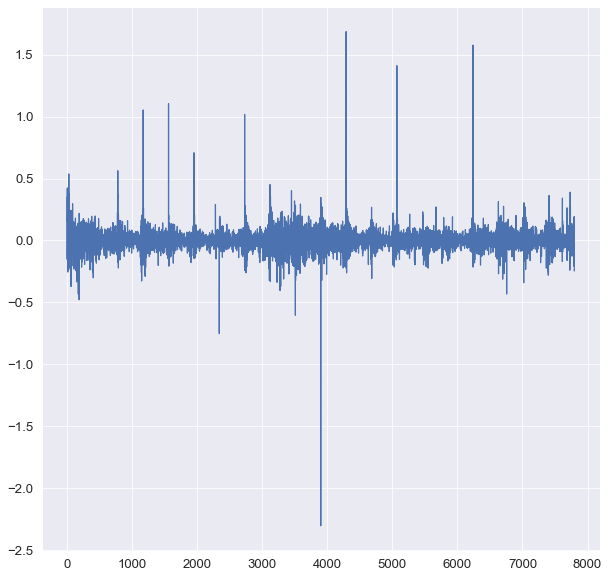

In [42]:
simple_returns.loc[:,'AAPL'].plot()

In [43]:
top = 0.999
upper_lim = simple_returns.loc[:,'AAPL'].quantile(top)
lower_lim = simple_returns.loc[:,'AAPL'].quantile(1-top)

In [44]:
test = simple_returns.loc[:,'AAPL'].copy(deep=True).values
test[test>upper_lim] = upper_lim
test[test<lower_lim] = lower_lim

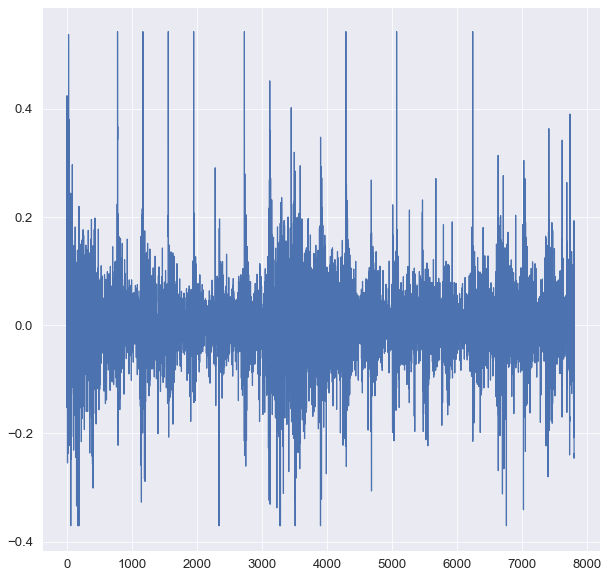

In [45]:
plt.plot(test)
plt.show()

In [46]:
_, splits = pd.qcut(test, q=n_classes, labels=False, retbins=True)
splits

array([-0.37061726, -0.02154649,  0.02365197,  0.54218692])

In [47]:
_, splits = pd.qcut(simple_returns.loc[:,'AAPL'], q=n_classes, labels=False, retbins=True)
splits

array([-2.30128226, -0.02154649,  0.02365197,  1.6849186 ])

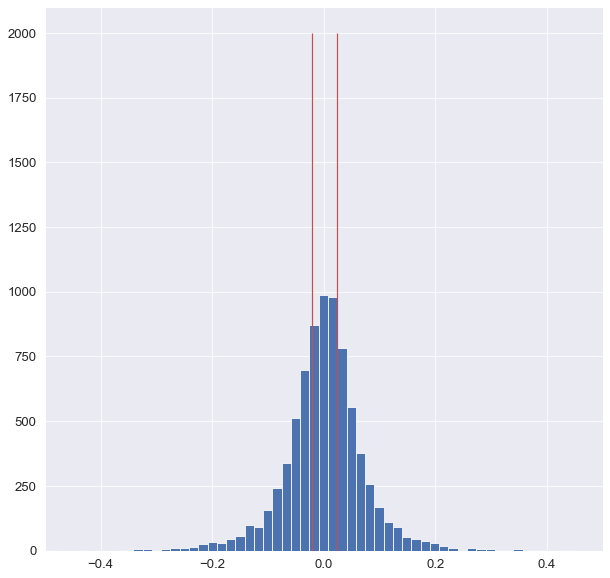

In [48]:
simple_returns.loc[:,'AAPL'].hist(bins=240)
plt.vlines(splits[1],ymin=0,ymax=2000,color='r')
plt.vlines(splits[2],ymin=0,ymax=2000,color='r')
plt.xlim(-0.5,0.5)
plt.show()

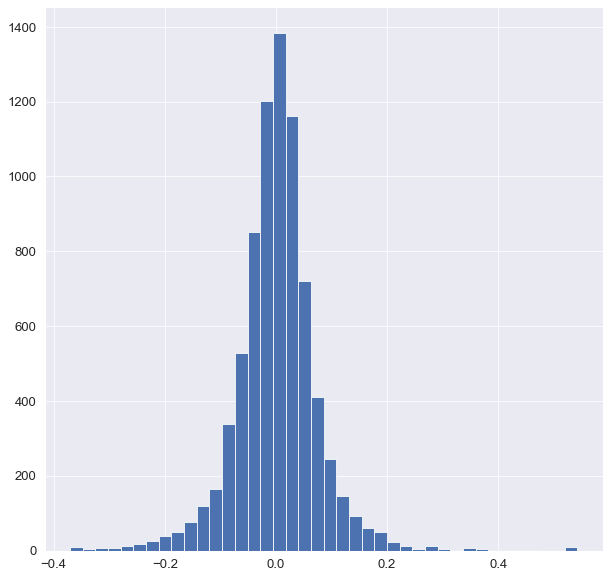

In [49]:
plt.hist(test,bins=40)
plt.show()

In [ ]:
stop

In [275]:
print('hej %.3f'%0.0025)

hej 0.003


In [207]:
(final_table.loc[:,'mean']*100).mean()

0.08394545454545455

In [229]:
def online_mean(old_mean,old_vals,new_vals,count):
    
    ## Running mean
#     updated_mean = old_mean + ((new_vals - old_vals) / count)
    
    ## Online mean
#     updated_mean = old_mean + ((new_vals) / count)
#     updated_mean += ((new_vals-old_mean) / count)

#     m2 = old_mean*count + (new_vals - old_mean)*(new_vals - updated_mean)

#     return updated_mean
    return old_mean+((new_vals-old_mean) / count)


In [255]:
final_table = final_table.reset_index(drop=True)#.sort_values('Avg spread')
final_table

,index,mean,std,min,max,Kurt,Skew,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread,Med spread,Med Return,Med Return 3,Med Return 5,Med Return 10
0,MSFT,0.00055,0.07757,-0.93733,1.22313,26.30,0.88,0.00469,0.01934,0.08766,0.01314,0.08192,0.010,0.011,0.00000,0.00538,0.00555,0.00544
1,AAPL,0.00125,0.08721,-2.30128,1.68492,113.27,0.50,0.00593,0.02881,0.01094,0.01987,0.00850,0.012,0.010,0.00002,0.00473,0.00785,0.01728
2,FB,0.00138,0.11167,-1.53383,3.38913,156.06,4.73,0.00973,0.03069,0.00673,0.02077,0.00596,0.018,0.017,0.00002,0.00468,0.00245,0.00933
3,INTC,0.00091,0.10827,-2.56367,2.81328,154.73,2.24,0.00914,0.01778,0.11641,0.01242,0.10278,0.019,0.017,0.00000,0.00000,0.00000,0.00000
4,WMT,0.00033,0.08389,-0.75896,3.21166,301.71,8.66,0.00549,-0.00289,0.79836,-0.00150,0.84251,0.022,0.016,0.00000,-0.00391,0.00000,-0.00400
5,BABA,0.00073,0.12805,-3.83373,3.69453,286.98,2.10,0.01279,0.02023,0.07410,0.01407,0.06256,0.023,0.020,0.00000,0.00000,0.00000,0.00255
6,TSM,-0.00046,0.09344,-2.75326,3.00171,334.57,4.68,0.00681,-0.00622,0.58301,-0.00474,0.53723,0.023,0.020,0.00000,0.00000,0.00000,-0.00953
7,V,0.00139,0.09773,-1.95861,2.61916,147.22,4.35,0.00745,0.01219,0.28172,0.00800,0.28946,0.024,0.021,0.00000,0.00261,0.00516,0.00784
8,KO,0.00037,0.09814,-0.88937,3.71974,426.94,12.61,0.00751,0.00823,0.46744,0.00522,0.49945,0.024,0.022,0.00000,0.00000,0.00000,0.00000
9,PEP,0.00005,0.07370,-0.91899,1.11049,26.82,1.23,0.00424,0.00799,0.48051,0.00549,0.46748,0.026,0.023,0.00000,0.00000,-0.00000,-0.00372


In [256]:
running_mean = 0
avg_median_spread = 0
mean_holder = []
median_holder = []

count = 1
for i in np.arange(final_table.shape[0]):
    running_mean = online_mean(running_mean,None,final_table.loc[i,'Med Return']*100,count)
    mean_holder.append(running_mean)
    avg_median_spread = online_mean(avg_median_spread,None,final_table.loc[i,'Med spread'],count)
    median_holder.append(avg_median_spread)
#     print(running_mean)
    count += 1

In [257]:
print(np.array(mean_holder),'\n\n',
      np.array(median_holder),'\n\n',
      np.array(mean_holder)-np.array(median_holder))

[0.         0.001      0.00133333 0.001      0.0008     0.00066667
 0.00057143 0.0005     0.00044444 0.0004     0.00036364 0.00033333
 0.00030769 0.00028571 0.00026667 0.00025    0.00023529 0.00022222
 0.00021053 0.0002     0.00019048 0.00018182 0.00017391 0.00016667
 0.00016    0.00015385 0.00014815 0.00014286 0.00013793 0.00016667
 0.00016129 0.00015625 0.00015152 0.00014706 0.00014286 0.00013889
 0.00018919 0.00018421 0.00017949 0.0002     0.0002439  0.0002381
 0.00023256 0.00022727 0.00022222 0.00021739 0.00021277 0.00020833
 0.00020408 0.0002     0.00019608 0.00019231 0.00018868 0.00018519
 0.00018182] 

 [0.011      0.0105     0.01266667 0.01375    0.0142     0.01516667
 0.01585714 0.0165     0.01711111 0.0177     0.01836364 0.01883333
 0.01946154 0.01992857 0.02013333 0.0203125  0.02070588 0.02144444
 0.02173684 0.02225    0.02285714 0.02345455 0.02382609 0.02441667
 0.025      0.02511538 0.02577778 0.02642857 0.02672414 0.0273
 0.02764516 0.02821875 0.02866667 0.02926471 0.03  

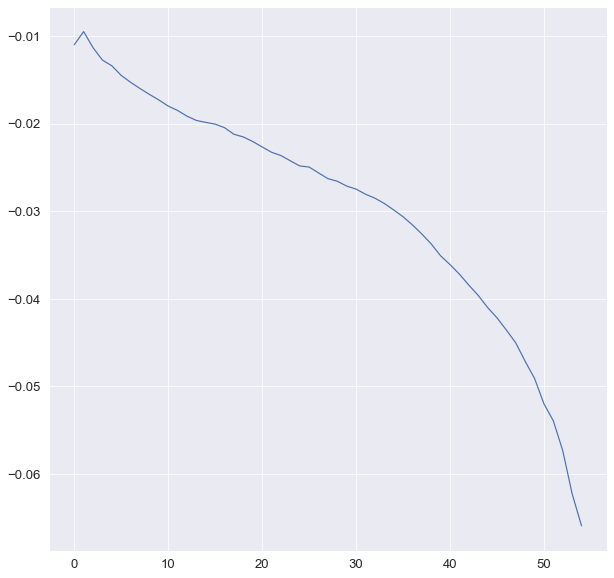

In [258]:
plt.plot(np.array(mean_holder)-np.array(median_holder))
plt.show()

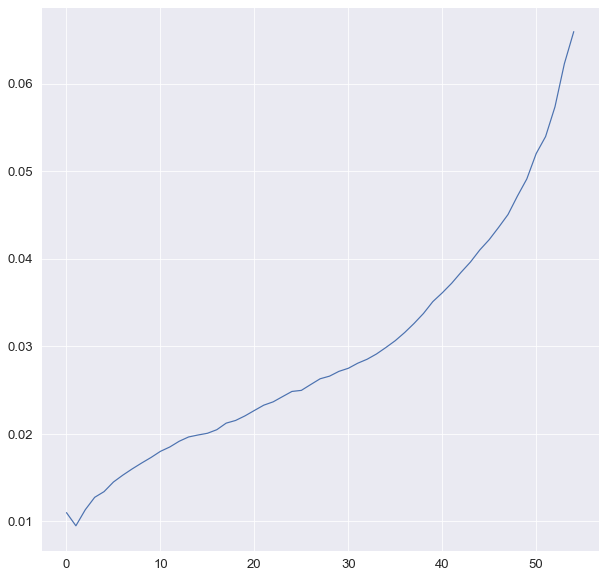

In [259]:
plt.plot(np.array(median_holder)-np.array(mean_holder))
plt.show()

In [261]:
mean_holder

[0.0,
 0.001,
 0.0013333333333333333,
 0.001,
 0.0008,
 0.0006666666666666668,
 0.0005714285714285715,
 0.0005,
 0.00044444444444444447,
 0.0004,
 0.00036363636363636367,
 0.0003333333333333334,
 0.00030769230769230776,
 0.0002857142857142858,
 0.00026666666666666673,
 0.00025000000000000006,
 0.00023529411764705888,
 0.0002222222222222223,
 0.00021052631578947375,
 0.00020000000000000006,
 0.00019047619047619054,
 0.00018181818181818186,
 0.0001739130434782609,
 0.00016666666666666672,
 0.00016000000000000004,
 0.00015384615384615388,
 0.00014814814814814817,
 0.00014285714285714287,
 0.00013793103448275863,
 0.00016666666666666666,
 0.00016129032258064516,
 0.00015625,
 0.00015151515151515152,
 0.00014705882352941175,
 0.00014285714285714284,
 0.00013888888888888886,
 0.00018918918918918917,
 0.00018421052631578945,
 0.00017948717948717947,
 0.00019999999999999998,
 0.00024390243902439022,
 0.00023809523809523807,
 0.0002325581395348837,
 0.00022727272727272727,
 0.000222222222222222

In [236]:
running_mean

0.08394545454545452

In [247]:
final_table

,index,mean,std,min,max,Kurt,Skew,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K,Avg spread,Med spread,Med Return 3,Med Return 5,Med Return 10
0,MSFT,0.00055,0.07757,-0.93733,1.22313,26.30,0.88,0.00469,0.01934,0.08766,0.01314,0.08192,0.010,0.011,0.00538,0.00555,0.00544
1,AAPL,0.00125,0.08721,-2.30128,1.68492,113.27,0.50,0.00593,0.02881,0.01094,0.01987,0.00850,0.012,0.010,0.00473,0.00785,0.01728
2,FB,0.00138,0.11167,-1.53383,3.38913,156.06,4.73,0.00973,0.03069,0.00673,0.02077,0.00596,0.018,0.017,0.00468,0.00245,0.00933
3,INTC,0.00091,0.10827,-2.56367,2.81328,154.73,2.24,0.00914,0.01778,0.11641,0.01242,0.10278,0.019,0.017,0.00000,0.00000,0.00000
4,WMT,0.00033,0.08389,-0.75896,3.21166,301.71,8.66,0.00549,-0.00289,0.79836,-0.00150,0.84251,0.022,0.016,-0.00391,0.00000,-0.00400
5,BABA,0.00073,0.12805,-3.83373,3.69453,286.98,2.10,0.01279,0.02023,0.07410,0.01407,0.06256,0.023,0.020,0.00000,0.00000,0.00255
6,TSM,-0.00046,0.09344,-2.75326,3.00171,334.57,4.68,0.00681,-0.00622,0.58301,-0.00474,0.53723,0.023,0.020,0.00000,0.00000,-0.00953
7,V,0.00139,0.09773,-1.95861,2.61916,147.22,4.35,0.00745,0.01219,0.28172,0.00800,0.28946,0.024,0.021,0.00261,0.00516,0.00784
8,KO,0.00037,0.09814,-0.88937,3.71974,426.94,12.61,0.00751,0.00823,0.46744,0.00522,0.49945,0.024,0.022,0.00000,0.00000,0.00000
9,PEP,0.00005,0.07370,-0.91899,1.11049,26.82,1.23,0.00424,0.00799,0.48051,0.00549,0.46748,0.026,0.023,0.00000,-0.00000,-0.00372


# Examining the effect of Data Transformations.

In [37]:
# Saving a copy of the returns
d = log_returns.copy(deep=True)

# Showing all available variables
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0', 'bidsize_low_lag0',
       'bidsize_close_lag0', 'ofrsize_open_lag0', 'ofrsize_high_lag0',
       'ofrsize_low_lag0', 'ofrsize_close_lag0', 'pastreturns_lag0',
       'intradaytime_lag0', 'open_lag1', 'high_lag1', 'low_lag1', 'close_lag1',
       'spread_open_lag1', 'spread_high_lag1', 'spread_low_lag1',
       'spread_close_lag1', 'bidsize_open_lag1', 'bidsize_high_lag1',
       'bidsize_low_lag1', 'bidsize_close_lag1', 'ofrsize_open_lag1',
       'ofrsize_high_lag1', 'ofrsize_low_lag1', 'ofrsize_close_lag1',
       'pastreturns_lag1', 'intradaytime_lag1', 'ticker'],
      dtype='object')

In [38]:
variables_to_investigate = X.loc[:,[True if (('lag0' in col) or\
                                            ('ticker' in col)) else  False for col in X.columns]].copy(deep=True)
variables_to_investigate

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,bidsize_low_lag0,bidsize_close_lag0,ofrsize_open_lag0,ofrsize_high_lag0,ofrsize_low_lag0,ofrsize_close_lag0,pastreturns_lag0,intradaytime_lag0,ticker
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,1.0,1.0,4.0,56.0,1.0,1.0,-0.000830,9.533333,AAPL
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,1.0,1.0,1.0,13.0,1.0,1.0,-0.001522,9.550000,AAPL
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,1.0,16.0,1.0,8.0,1.0,1.0,0.001785,9.566667,AAPL
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,1.0,1.0,1.0,236.0,1.0,1.0,0.004237,9.583333,AAPL
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,1.0,1.0,1.0,18.0,1.0,1.0,-0.000809,9.600000,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428885,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,1.0,1.0,7.0,8.0,1.0,4.0,0.000848,15.916667,WMT
428886,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,1.0,1.0,5.0,9.0,1.0,1.0,0.001210,15.933333,WMT
428887,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,1.0,3.0,1.0,9.0,1.0,2.0,-0.000846,15.950000,WMT
428888,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,1.0,2.0,2.0,10.0,1.0,2.0,0.002742,15.966667,WMT


# Apple

In [55]:
ticker = 'AAPL'

t = np.arange(len(d.columns))

temp_vi = variables_to_investigate[variables_to_investigate.ticker==ticker]

for i,var in enumerate(temp_vi):
    
    temp_vi = variables_to_investigate[variables_to_investigate.ticker==ticker]
    
    if 'ticker' not in var:

        ##### Autocorrelations
        ## Pearsons
        try:
            autocorr = np.correlate(d.iloc[0:-1,t[d.columns==ticker]].values[:,0] / 100,
                                        temp_vi.loc[:,var].values,
                                        mode='full')
            autocorr = autocorr[autocorr.size//2:]
        except:
            print(var)

        ## Spearmans
        try:
            s_auto,p_val = spearmanr(d.iloc[0:-1,t[d.columns==ticker]].values[:,0] / 100,
                                     temp_vi.loc[:,var].values)#d.loc[0:-1,ticker]
        except:
            print(var)

        ## Kendalls
        try:
            k_auto,pval = kendalltau(d.iloc[0:-1,t[d.columns==ticker]].values[:,0] / 100,
                                     temp_vi.loc[:,var].values)
        except:
            print(var)

        if i == 0:

            metrics = pd.DataFrame(columns=['Corr_P','Corr_S','P_val_S','Corr_K','P_val_K'])

        metrics.loc[var,['Corr_P','Corr_S','P_val_S'
                            ,'Corr_K','P_val_K']] = [autocorr[0],
                                                     s_auto,
                                                     p_val,
                                                     k_auto,
                                                     pval]

C:\Users\PC\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\PC\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\PC\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\PC\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\PC\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [56]:
metrics

,Corr_P,Corr_S,P_val_S,Corr_K,P_val_K
open_lag0,-1.23626,-0.994855,0,-0.97362,0
high_lag0,-0.594756,-0.675713,0,-0.513055,0
low_lag0,-0.588629,-0.660359,0,-0.502229,0
close_lag0,30.328,-0.00274192,0.80871,-0.00193815,0.797474
spread_open_lag0,0.0260289,-0.0059969,0.59647,-0.00399919,0.612182
spread_high_lag0,0.0127081,-0.0269284,0.0174069,-0.0178494,0.0222063
spread_low_lag0,0.00101803,0.00865359,0.444833,0.00705488,0.445076
spread_close_lag0,0.00361726,-0.043454,0.000123809,-0.0315702,6.52132e-05
bidsize_open_lag0,0.474732,-0.000371794,0.973813,-0.000242073,0.977852
bidsize_high_lag0,-25.6018,-0.129521,1.58675e-30,-0.0897907,2.47671e-30


# Let's visulise the data

In [43]:
temp_vi

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,bidsize_low_lag0,bidsize_close_lag0,ofrsize_open_lag0,ofrsize_high_lag0,ofrsize_low_lag0,ofrsize_close_lag0,pastreturns_lag0,intradaytime_lag0,ticker
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,1.0,1.0,4.0,56.0,1.0,1.0,-0.000830,9.533333,AAPL
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,1.0,1.0,1.0,13.0,1.0,1.0,-0.001522,9.550000,AAPL
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,1.0,16.0,1.0,8.0,1.0,1.0,0.001785,9.566667,AAPL
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,1.0,1.0,1.0,236.0,1.0,1.0,0.004237,9.583333,AAPL
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,1.0,1.0,1.0,18.0,1.0,1.0,-0.000809,9.600000,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7793,0.660,0.780,-0.035,319.250,0.02,0.38,0.01,0.10,2.0,41.0,1.0,2.0,1.0,56.0,1.0,1.0,-0.002079,15.916667,AAPL
7794,0.160,0.320,-0.265,319.095,0.11,0.17,0.01,0.05,2.0,485.0,1.0,1.0,1.0,22.0,1.0,7.0,-0.000486,15.933333,AAPL
7795,0.250,0.450,-0.035,318.845,0.05,0.22,0.01,0.03,1.0,20.0,1.0,2.0,6.0,11.0,1.0,1.0,-0.000783,15.950000,AAPL
7796,-0.615,0.145,-0.765,319.460,0.03,0.11,0.01,0.06,1.0,10.0,1.0,2.0,1.0,9.0,1.0,6.0,0.001929,15.966667,AAPL


In [44]:
temp_vi.columns.values

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'pastreturns_lag0', 'intradaytime_lag0', 'ticker'], dtype=object)

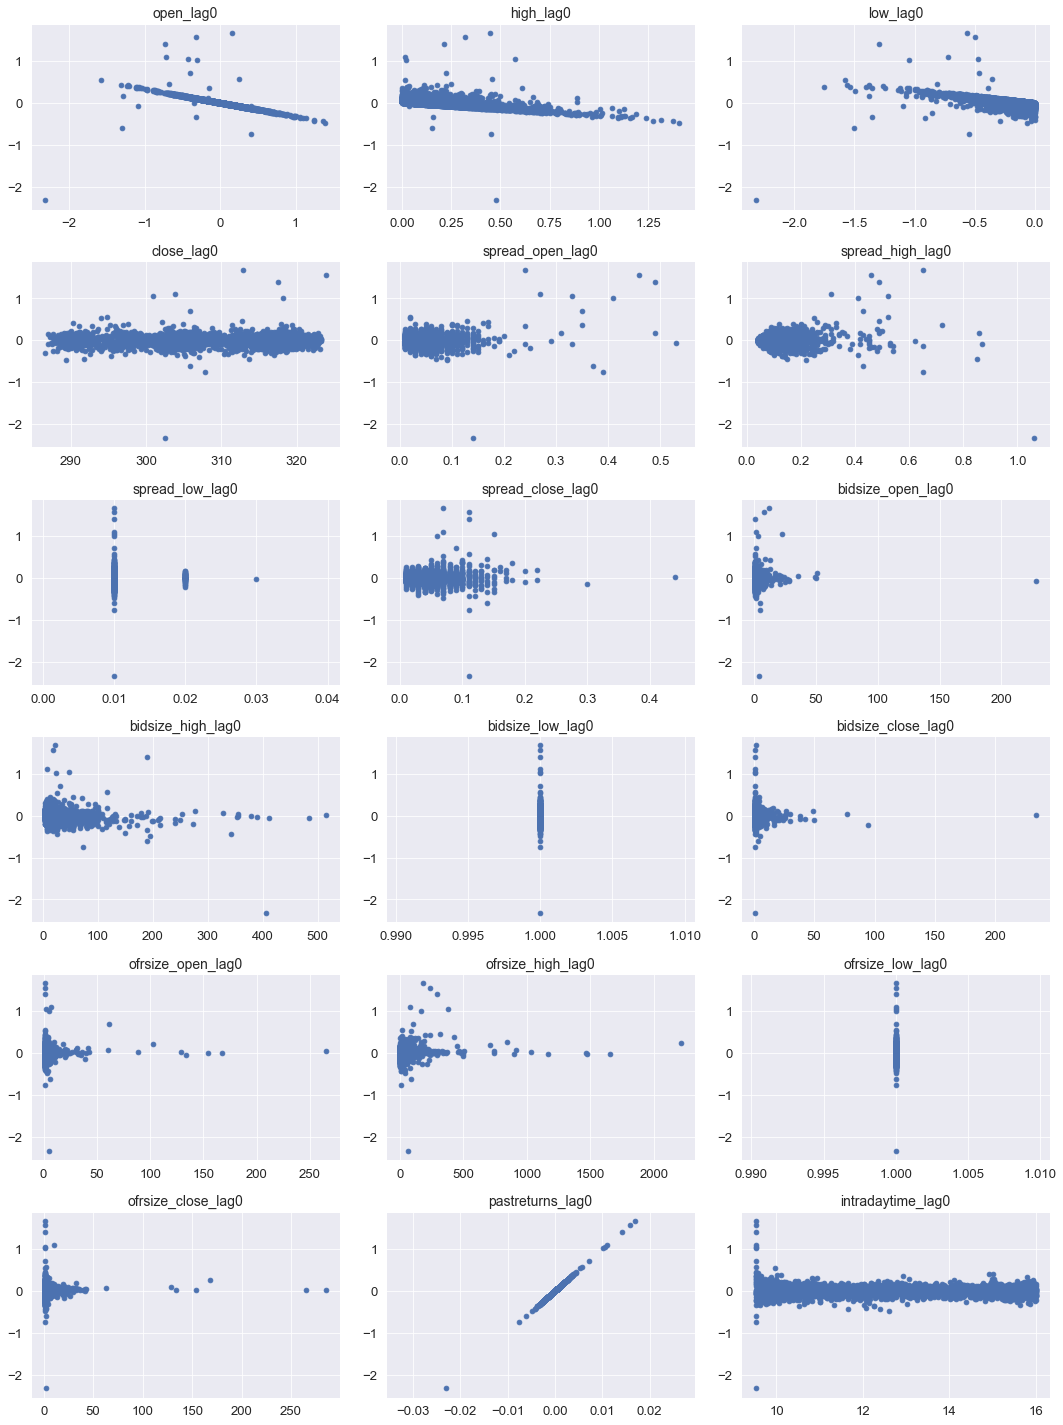

In [58]:
## Choose a ticker to show
ticker = 'AAPL'

## Getting the return and the days at which they occured.
# temp = log_returns.loc[:,[ticker,'Day']]
rows = 6
cols = 3
## Getting the variables.
variables = temp_vi.columns.values
variables = variables[variables != 'ticker']
## Plotting the histogram of the returns for each day.
fig,ax = plt.subplots(rows,cols,figsize=(15,20))

l = 0

for i in np.arange(rows):
    for j in np.arange(cols):
        if l < len(variables):
#         print(temp[temp.Day==days[l]][ticker].astype(float).values.round(4))
#         ax[i,j].hist(temp[temp.Day==days[l]][ticker].values,bins='40')
            ax[i,j].scatter(x=temp_vi.loc[:,variables[l]].values,
                                y=d.iloc[0:-1,t[d.columns==ticker]].values[:,0])
            ax[i,j].set_title(variables[l],fontsize=14)
        #         ax[i,j].set_xlim(temp[ticker].min(),temp[ticker].max())
        #         ax[i,j].set_xlim(-0.5,0.5)
        #         ax[i,j].set_ylim(0,80)
            l += 1

fig.tight_layout(pad = 1)
plt.show()

In [ ]:
stop

# All tickers

In [54]:
d = log_returns.copy(deep=True)

for i,ticker in enumerate(data.Ticker.unique()):
    temp_vi = variables_to_investigate[variables_to_investigate.ticker==ticker]
    for var in temp_vi:
        
        if ~('ticker' in var):
            
            ##### Autocorrelations
            ## Pearsons
            autocorr = np.correlate(d.loc[:,ticker],
                                        temp_vi.loc[:,var],
                                        mode='full')
            autocorr = autocorr[autocorr.size//2:]

            ## Spearmans
            s_auto,p_val = spearmanr(d.loc[:,ticker],temp_vi.loc[:,var])

            ## Kendalls
            k_auto,pval = kendalltau(d.loc[:,ticker],temp_vi.loc[:,var])

            if i == 0:

                metrics = pd.DataFrame(columns=['Corr_P','Corr_S','P_val_S','Corr_K','P_val_K'])

            metrics.loc[ticker,['Corr_P','Corr_S','P_val_S'
                                ,'Corr_K','P_val_K']] = [autocorr[0],
                                                         s_auto,
                                                         p_val,
                                                         k_auto,
                                                         pval]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 7799 and the array at index 1 has size 7798

## Adding ticker dummies

In [ ]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [ ]:
X.columns

## Constructing our final train/validation sets

In [ ]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.astype({'days':int,'timestamps':int}).sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

test_index = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].index
test_index = tempIndices.loc[test_index]

train_index = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].index
train_index = tempIndices.loc[train_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

In [ ]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(X_train.columns)}

In [ ]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

In [ ]:
X_train.iloc[:,0].mean(),X_train.iloc[:,0].std()

In [ ]:
X_test.iloc[:,0].mean(),X_test.iloc[:,0].std()

## Prepping for models

In [ ]:
N_VALIDATION = y_test.shape[0] #int(1e3)
N_TRAIN = y_train.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 50

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X_train.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

In [ ]:
np.unique(y_test, return_counts=True)

In [ ]:
y_test

## A Logistic Regression model in TF/Keras

In [ ]:
one_hot = True
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

if one_hot:
    y_train_1h = one_hot_encode(y_train.values.astype(np.int), n_classes)
    y_test_1h = one_hot_encode(y_test.values.astype(np.int), n_classes)

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(5,
                       input_shape=(FEATURES,),
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),#'categorical_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping
             #tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            X_train, #train_features,
                            y_train_1h, #y_train, #train_labels,
                            batch_size=3300, #BATCH_SIZE,
                            epochs=50, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(X_test, y_test_1h),
                            verbose=0) #(val_features, val_labels))

In [ ]:
model.evaluate(X_test,  y_test_1h, verbose=2)

In [ ]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [ ]:
probs= model.predict(X_test, verbose=1)
probs

## Update indices of data

In [ ]:
X_test.set_index(pd.MultiIndex.from_frame(test_index), inplace=True)
X_train.set_index(pd.MultiIndex.from_frame(train_index), inplace=True)
X_test

In [ ]:
preds = pd.DataFrame(model.predict(X_test, verbose=1))
preds
# preds[0] = 1 - preds[1]

In [ ]:
preds['class'] = preds.iloc[:,0:5].values.argmax(axis=1)
preds['confidence'] = preds.iloc[:,0:-2].values.max(axis=1)
preds = preds.set_index(X_test.index) #.loc[(20200526,0)]
preds

In [ ]:
np.unique(preds['class'], return_counts=True)

In [ ]:
probs

In [ ]:
## Setting one day to investigate
temp = preds.loc[20200526,0]

probs = pd.DataFrame(columns=['ticker','prob','class'])
## Adding class 0
probs[['ticker','prob','class']] = temp[temp['class'] == 0][[0,'class']].reset_index().copy(deep=True)
# ## Adding class 4
probs = pd.concat([probs,temp[temp['class'] == 4][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})],
                  axis=0)

# ## Adding other classes - NB: We have randomly selected the probs from columns 4 - we would have chosen any of the columns.
# probs = pd.concat([probs,temp[(temp['class'] != 0)|(temp['class'] != 4)][[4,'class']].reset_index().copy(deep=True)])
probs = pd.concat([probs,
                   temp[~temp['class'].isin([0,4])][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})]).reset_index(drop=True)
# # setting the probs of classes different from 0 and 4 to zero.
probs.loc[~probs['class'].isin([0,4]),'prob'] = 0

# Weights
probs['weight'] = probs.prob / probs.prob.sum()

# directions
probs['direction'] = 0#probs.prob / probs.prob.sum()
probs.loc[probs['class'].isin([0]),'direction'] = -1
probs.loc[probs['class'].isin([4]),'direction'] = 1

probs = probs.sort_values(['class','ticker'])

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(x = probs.ticker,
        height = probs.weight*probs.direction)
plt.xticks(rotation=60)
plt.show()

In [ ]:
probs.prob.sum()

In [ ]:
probs.weight.sum()

In [ ]:
data.Ticker.unique()

## Introducing the stop-loss / profit-goal option

In [ ]:
def returns(price_data,horizon):
    
    return (price_data.values[1:]/price_data.values[0:-1])-1


In [ ]:
### Recreating the price series for each tradable ticker
X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
                          if 'd_ticker' in i])

cp_x_train = pd.DataFrame(actual_series_train.T,
                         columns=data.Ticker.unique())


### Recreating the price series for each tradable ticker
X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_test = np.array([X_test_temp[X_test_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

cp_x_test = pd.DataFrame(indexed_series_test.T,
                         columns=data.Ticker.unique())

### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

### Recreating the price series for each ETF

actual_series_etfs = np.array([sector_test[sector_test['Ticker']==i].close.reset_index(drop=True).values\
                          for i in sector_test.Ticker.unique()])

indexed_series_etfs = np.divide(actual_series_etfs,actual_series_etfs.T[0].reshape(-1,1))*100

cp_sector_test = pd.DataFrame(indexed_series_etfs.T,
                         columns=sector_test.Ticker.unique())

## Simple way of calculating the standard deviation over a fixed window
The online optione below can be adjusted based on [this](https://lingpipe-blog.com/2009/07/07/welford-s-algorithm-delete-online-mean-variance-deviation/) reference, to do the same.

In [ ]:
horizon = 5

print(cp_x_train.iloc[-horizon:,0:2])
returns_container = returns(cp_x_train.iloc[-(horizon+1):,:],
                            horizon)
max_steps = 0
output_container = np.zeros((max_steps+1,
                             len(data.Ticker.unique())))

output_container[0] = np.std(returns_container,axis=0)
for i,j in enumerate(np.arange(max_steps)):

    returns_container[0:-1] = returns_container[1:]
    print(i)
    if i == 0:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_train.T[-1])-1
    
    else:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_test.T[i-1])-1
    
    output_container[i+1] = np.std(returns_container,axis=0)

## Online standard deviation calculations

In [ ]:
def online_std(initial_vals,horizon,new_vals,count=0,m2=0):
    
    ## We take a set of initial values, from which we calculate a running mean
    
    if count == 0:
        count = horizon + 1
        
    else:
        count += 1
    print(count)
    
    updated_vals = initial_vals + ((new_vals[0] - initial_vals) / count)

    m2 = initial_vals*(count-1) + (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)

    return updated_vals,m2,count

def online_std_fixed(old_mean,old_vals,new_vals,horizon):
    
    ## We take a set of initial values, from which we calculate a running mean

    updated_mean = old_mean + ((new_vals - old_vals) / horizon)

    m2 = old_mean*horizon + (new_vals - old_mean)*(new_vals - updated_mean)

    return updated_mean,m2,horizon

In [ ]:
os.listdir('../../')

In [ ]:
preds = pd.read_excel('../../predications_13_10_2020.xlsx',index_col=[0,1,2])

In [ ]:
preds

# Backtest module

In [ ]:
'''
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

2) Max_positions: Check if the specified number of max positions results in an uneven split? like max position = 9.
'''


class backtest():
    def __init__(self,
                 X_test,
#                  X_train,
                 data,
                 preds,
                 weight_scheme,
                 rebal_scheme,
                 strategy_scheme,
                 # rebal_init_data,
                 # rebal_last_known_price,
                 # rebal_lookback_horizon,
                 # rebal_risk_aversion,
                 max_steps,
                 max_positions,
                 n_classes,
                 slpg_warning = False,
                 slpg_input = {},
                 return_revealer = 1000,
                 zero_spread = False,
                 verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'

        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.hist_directions = np.zeros((max_steps,len(self.all_tickers)))
        self.hist_prev_weights = np.zeros((max_steps,len(self.all_tickers)))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.strategy_scheme = strategy_scheme
        self.rebal_scheme = rebal_scheme
        self.slpg_warning = slpg_warning
        self.slpg_init_data = slpg_input['init_data']
        self.slpg_last_known_price = slpg_input['last_known_price']
        self.slpg_lookback_horizon = slpg_input['lookback_horizon']
        self.slpg_risk_aversion = slpg_input['risk_aversion']
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.return_revealer = return_revealer
        self.zero_spread = zero_spread
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')

    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        if self.verbose >= 1: print(self.all_tickers,'\n')

        if self.slpg_warning: # slpg: Stop Loss / Profit Goal

            self.returns_container = returns(self.slpg_init_data,#cp_x_train.iloc[-(self.rebal_lookback_horizon+1):,:]
                                        self.slpg_lookback_horizon)

            self.output_container = np.zeros((self.max_steps,
                                         len(self.all_tickers)))

        self.ticker_dict = {i:j for i,j in enumerate(self.all_tickers)}

        if self.verbose >= 1: print('Size of returns container: ', self.returns_container.shape)
            
        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            if self.verbose >= 1: print(ts)
            if self.verbose >= 1: print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]
            
            if self.zero_spread:
                close_info.loc[:,'spread_close'] = 0

            self.update_positions(ts, close_info, ts_preds)#,self.rebal_scheme
            
            ## Print the current portfolio return if the step are in the sequence. 
            if self.t in np.arange(self.return_revealer,self.max_steps+self.return_revealer,self.return_revealer):
                
                print('Step %i - Current return: %.3f'%(self.t,self.hist_rets[self.t,-1]))
            
            self.t += 1

        if self.verbose >= 1: print(f'run function finished at step {self.t}, time: {ts}')

    def update_positions(self, ts, close_info, ts_preds):#,rebal_scheme
        
#         if self.t >= 291:
#             self.verbose = 1

        # Long positions
        long_pos = ts_preds[ts_preds['class'] == (self.n_classes - 1)].sort_values('confidence',
                                                                                   ascending=False)
        # Short positions
        short_pos = ts_preds[ts_preds['class'] == 0].sort_values('confidence',ascending=False)

        # The choice of strategy scheme determines the actions going forward
        if self.strategy_scheme == 'max_pos':

            ## Open all available long positions if the number of available long positions are less than the
            ## intended number of long positions.
            if (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.index.values

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_list)+\
                                                                                                                len(short_list),self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
                short_list = short_pos.iloc[0:int(self.max_positions/2),:].index.values

            ## If there are less long and excess short positions:
            elif (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions-short_pos.shape[0]),:].index.values
                short_list = short_pos.index.values

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        ## If "None" strategy scheme is chosen, all candicates are chosen.
        elif self.strategy_scheme == None:

            long_list = long_pos.index.values
            short_list = short_pos.index.values

        ## Else return eror
        else:

            raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # check if any new positions are made
        new_long = long_list[~np.isin(long_list, self.open_long_positions)]
        new_short = short_list[~np.isin(short_list, self.open_short_positions)]

        ###### check if any needs closed before we determine if any new ones should be
        ###### disregarded.

        ## Closing those that have changed signal.
        close_long = list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
        close_short = list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])

        ## Meant to check if time to close positions due to stop loss or profit goal.
        ## However, at the moment we just inform about positions that exceeds either of the thresholds.
        if (self.t > 0) & (self.slpg_warning):

            positions_above_pg = np.where(self.hist_rets[self.t-1][0:-1]>(1+self.output_container[self.t-1]*self.slpg_risk_aversion[1]))[0]
            positions_below_sl = np.where(self.hist_rets[self.t-1][0:-1]<(1+self.output_container[self.t-1]*self.slpg_risk_aversion[0]*-1))[0]

            print('Number of positions above profit goal: ',len(positions_above_pg))

            if len(positions_above_pg) > 0:
                print('Positionns exceeding the profit goal: ',[(self.ticker_dict[i],i) for i in positions_above_pg],'\n')

            print('Number of positions below stop loss: ',len(positions_below_sl))

            if len(positions_below_sl) > 0:
                print('Positionns exceeding the stop loss: ',[(self.ticker_dict[i],i) for i in positions_below_sl])

        if self.verbose >= 1:
            print(f'\nclose_long: {close_long}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_long]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.strategy_scheme == 'max_pos':

            long_candidates = self.open_long_positions+list(new_long)
            short_candidates = self.open_short_positions+list(new_short)

            ## Checking if any of the new candidates should be included or any of the existing should be closed
            ## at the expense of a new.
            if (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) <= (self.max_positions / 2)):

                # Do nothing, sticking with the generated list, consisting of open positions and new buys!
                pass

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_candidates)+\
                                                                                                                len(short_candidates),
                                                                                                                 self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (len(long_candidates) > (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ### Prepping the candidates
                temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values
                temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                # Determining the ranking of the new candidates
                new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]
                new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                # Determining the ranking of the existing positions
                open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]
                open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                # if some new buy candidates have a ranking that is outside the desired long positions,
                # we diregard that new buy.
                if len(new_long_ranking) > 0:
                    if (max(new_long_ranking) > ((self.max_positions / 2) - 1)):
                        new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if len(new_short_ranking) > 0:
                    if (max(new_short_ranking) > ((self.max_positions / 2) - 1)):
                        new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                ## we close it.
                if len(open_long_ranking) > 0:
                    if (max(open_long_ranking) > ((self.max_positions / 2) - 1)):
                        self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if len(open_short_ranking) > 0:
                    if (max(open_short_ranking) > ((self.max_positions / 2) - 1)):
                        self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]

            ## If there are less long and excess short positions:
            elif (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ## With less long candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a buy signal anymore but then they are dropped above,
                ## and new ones should be added.
                ## For the sell candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.

                if len(short_candidates) >= (self.max_positions - len(long_candidates)):

                    temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                    # Determining the ranking of the existing positions
                    open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if len(new_short_ranking) > 0:
                        if (max(new_short_ranking) > ((self.max_positions / 2) - 1)):
                            new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
#                     try:
                    if len(open_short_ranking) > 0:
                        if (max(open_short_ranking) > ((self.max_positions / 2) - 1)):
                            self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                            close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]
#                     except:
#                         print('Step:\n\n'self.t,'\n')
#                         print('open short positions:\n\n',self.open_short_positions,'\n')

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                ### Vice versa, compared to the if statement just above.

                ## With less sell candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a sell signal anymore but then they are dropped below,
                ## and new ones should be added.

                ## For the short candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.
                if len(long_candidates) >= (self.max_positions - len(short_candidates)):

                    temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]

                    # Determining the ranking of the existing positions
                    open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if len(new_long_ranking) > 0:
                        if (max(new_long_ranking) > ((self.max_positions / 2) - 1)):
                            new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
                    if len(open_long_ranking) > 0:
                        if (max(open_long_ranking) > ((self.max_positions / 2) - 1)):
                            self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                            close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'new_long: {new_long}')
            print(f'new_short: {new_short} \n')

        self.open_long_positions += [long_i for long_i in new_long]
        self.open_short_positions += [short_i for short_i in new_short]

        #self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')
        
        ########## Calculating returns ##########
        
        if self.t > 0:
            
            if self.verbose >= 1: print('self.prev_close.direction new step:\n\n',self.prev_close.direction,'\n')
                
#             print('\nIndex 37 direction before return calculation: ',self.prev_close.iloc[37, 1],'\n')
            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction'] = -1
#             print('\nIndex 37 direction, before return but after adjustment: ',self.prev_close.iloc[37, 1],'\n')
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
            
#             print('Current ret, index 37: ',current_ret[37],'\n')
            
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_long)
            
#             print('\nIndex 37: ',boolcousin[37],'\n')
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values - 1
            
            ## We multiply with the opposite direction to get the correct return.
            current_ret[boolcousin] = (current_ret[boolcousin] * -self.prev_close[boolcousin].direction.values) + 1
            
#             print('portfolio return, accumulated, before:\n\n',current_ret.sum()*self.hist_rets[self.t - 1, -1],'\n')
#             print('Current ret with bool cousin, index 37: ',current_ret[37],'\n')
#             print('Prev close: \n\n',self.prev_close)
            ## Correcting the return of those we rebalance
            #self.prev_close.direction.values != 0&
#             rebal_mask = (self.prev_close.direction.values != 0)&(~(np.isin(self.all_tickers,new_long)|\
#                             np.isin(self.all_tickers,new_short)|np.isin(self.all_tickers,close_long)|
#                             np.isin(self.all_tickers,close_short)))
            
            # Preparing the generation of the new weights
            future_direction = self.prev_close.direction.copy(deep=True)
            
            if self.verbose >= 1: print('future_direction 1:\n\n',future_direction,'\n')
            
            # set directions == 0 for closed positions
            future_direction[np.isin(self.all_tickers, close_long)] = 0
            future_direction[np.isin(self.all_tickers, close_short)] = 0            
            
            if self.verbose >= 1: print('future_direction 2:\n\n',future_direction,'\n')
            
            # update directions for new positions
            future_direction[np.isin(self.all_tickers, new_long)] = 1
            future_direction[np.isin(self.all_tickers, new_short)] = -1
            
            if self.verbose >= 1: print('future_direction 3:\n\n',future_direction,'\n')
            if self.verbose >= 1: print('future_direction 3 abs:\n\n',future_direction.abs(),'\n')
            if self.verbose >= 1: print('future_direction 3 abs-sum:\n\n',future_direction.abs().sum(),'\n')
        
            if self.weight_scheme == 'constant':
                
                # Set new weights
                new_weights = (1/future_direction.abs().sum())*future_direction.abs()

            elif self.weight_scheme == 'prob':
#                 print('Predictions: \n',ts_preds,'\n')
                new_weights = ((ts_preds.confidence)*future_direction.abs())/((ts_preds.confidence)*future_direction.abs()).sum()

            if self.verbose >= 1: print('New weights:\n\n',new_weights,'\n')
            if self.verbose >= 1: print('noob')
            
            if self.verbose >= 1: print('previous weights:\n\n',self.hist_prev_weights[self.t - 1],'\n')
            
            portfolio_dev = current_ret * self.hist_prev_weights[self.t - 1,:]
            
            if self.verbose >= 1: print('portfolio development, before correction:\n\n',portfolio_dev,'\n')
            
            portfolio_share = portfolio_dev / sum(portfolio_dev)
            
            if self.verbose >= 1: print('portfolio share:\n\n',portfolio_share,'\n')
            
            correction = np.zeros(len(portfolio_share))
            
            if self.verbose >= 1: print('correction mask:\n\n',(new_weights != 0)&(self.hist_directions[self.t - 1]==future_direction),'\n')
            
            correction_mask = ((new_weights != 0)&(self.hist_directions[self.t - 1]==future_direction)).values
            
            correction[correction_mask] = new_weights[correction_mask] / portfolio_share[correction_mask] - 1
            
            if self.verbose >= 1: print('correction:\n\n',correction,'\n')
            
            share_to_keep = 1-abs(correction)
            share_to_correct = abs(correction)
            if self.verbose >= 1: print('share_to_keep: \n\n',share_to_keep,'\n')
            
#             print(share_to_keep.shape,current_ret.shape,correction_mask.shape)
#             print('rebal_mask:\n\n',rebal_mask,'\n')
#             print('correction_mask:\n\n',correction_mask,'\n')
            
            if self.verbose >= 1: print('return of share to keep:\n\n',share_to_keep[correction_mask] * current_ret[correction_mask],'\n')
            if self.verbose >= 1: print('return of share to correct:\n\n',share_to_correct[correction_mask] * ((close_info[correction_mask].close.values\
                                                             *abs(self.prev_close[correction_mask].direction.values)\
                                                             +(close_info[correction_mask].spread_close.values / 2)\
                                                             *-1*self.prev_close[correction_mask].direction.values)\
                                                            /self.prev_close[correction_mask].prev_close.values),'<n')
            current_ret[correction_mask] =  share_to_keep[correction_mask] * current_ret[correction_mask] +\
                                            share_to_correct[correction_mask] * ((close_info[correction_mask].close.values\
                                                             *abs(self.prev_close[correction_mask].direction.values)\
                                                             +(close_info[correction_mask].spread_close.values / 2)\
                                                             *-1*self.prev_close[correction_mask].direction.values)\
                                                            /self.prev_close[correction_mask].prev_close.values)#- 1
            
            if self.verbose >= 1: print('return after: \n\n',current_ret[correction_mask],'\n')
            
            portfolio_dev[correction_mask] = current_ret[correction_mask] * self.hist_prev_weights[self.t - 1,correction_mask]
            
            if self.verbose >= 1: print('portfolio development, after correction:\n\n',portfolio_dev,'\n')
            
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
            current_ret[self.prev_close.direction.values == 0] = 1
            
            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]
            
            # update total portfolio returns for open positions
#             self.hist_rets[self.t, -1] = (1+sum(((current_ret*self.prev_close.direction.abs().values) - 1)*self.hist_prev_weights[self.t - 1])) * self.hist_rets[self.t - 1, -1]
            
            self.hist_rets[self.t, -1] = sum(portfolio_dev)*self.hist_rets[self.t-1, -1]
        
            if self.verbose >= 1: print('portfolio return, accumulated, after:\n\n',self.hist_rets[self.t, -1],'\n')
            
            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0            
            
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1

            if self.slpg_warning:
                ## Roll back return matrix, to make room to the return coming in at the end of the period.
                self.returns_container[0:-1] = self.returns_container[1:]

                ## Include the new return.
                self.returns_container[-1] = (close_info.close.values/self.prev_close.prev_close)-1

                ## Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            ## Updating the last seen price
            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            ## Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            ## Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2
            overlap = []
#             print(np.isin(new_long,close_long))
#             print(close_long)
            overlap += list(np.array(close_long)[np.isin(close_long, new_long)])
            if len(overlap) > 0:
                print('New longs in close long: ', overlap)

            overlap += list(np.array(new_long)[np.isin(new_long, close_long)])
            if len(overlap) > 0:
                print('Close longs in new long: ', overlap)

            overlap += list(np.array(close_short)[np.isin(close_short, new_short)])
            if len(overlap) > 0:
                print('New shorts in close short: ', overlap)

            overlap += list(np.array(new_short)[np.isin(new_short, close_short)])
            if len(overlap) > 0:
                print('Close shorts in new short: ', overlap)

            if len(overlap) > 0:
                print('######### Overlap between the new candidates and the close candidates #########')

#             # set directions == 0 for closed positions
#             self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
#             self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0
            
            ## Setting the weights for the open positions in the next period.
            if self.weight_scheme == 'constant':
                
                # Set new weights
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()

            elif self.weight_scheme == 'prob':

                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)

        else:

            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            
            ## Initializing the weights
            if self.weight_scheme == 'constant':
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()

            elif self.weight_scheme == 'prob':

                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()

            if self.slpg_warning:

                ## Place to update returns in the returns container
                # Roll back the returns one period
                self.returns_container[0:-1] = self.returns_container[1:]

                # Include the new return
                self.returns_container[-1] = (close_info.close.values/self.slpg_last_known_price)-1

                # Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)

######### A little initialization ###########
max_steps = 1559
slpg_lookback_horizon = 10
slpg_init_data = cp_x_train.iloc[-(slpg_lookback_horizon+1):,:]
slpg_last_known_price = cp_x_train.iloc[-1,:].T

slpg_input = {'init_data':slpg_init_data,
              'last_known_price':slpg_last_known_price,
              'lookback_horizon':slpg_lookback_horizon,
              'risk_aversion':(2,4)}

backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = 'prob',
                        rebal_scheme = 'slpg',
                        strategy_scheme = 'max_pos',### Options: 'max_pos',None
#                         rebal_init_data = rebal_init_data,
#                         rebal_last_known_price = rebal_last_known_price,
#                         rebal_lookback_horizon = rebal_lookback_horizon,
#                         rebal_risk_aversion = (2,4),
                        max_steps=max_steps,
                        max_positions = 5,
                        n_classes=5,
                        slpg_warning = False,
                        slpg_input = slpg_input,
                        return_revealer = 1,
                        zero_spread = False,
                        verbose=False)
start = time.time()
backtest_obj.run()
end = time.time()
print('Processing time : %.3f minutes' %((end-start)/60))
print('final return: %.3f' % backtest_obj.hist_rets[-1,-1])

In [ ]:
(end-start)/60

In [ ]:
print('Processing time : %.3f minutes' %((end-start)/60))
print('final return: %.3f' % backtest_obj.hist_rets[-1,-1])

In [ ]:
preds.index.get_level_values(0).unique(),preds.index.get_level_values(1).unique()

In [ ]:
3*390+389

In [ ]:
preds

In [ ]:
preds.loc[20200529,389]

In [ ]:
preds.shape

In [ ]:
pot_returns = backtest_obj.hist_rets

### Storing returns in PD
pot_returns_pd = pd.DataFrame(pot_returns,columns = np.concatenate([data.Ticker.unique(),['Portfolio']]))

ticker_dict = {j:i for i,j in enumerate(pot_returns_pd.columns)}
ticker_dict

In [ ]:
pnl_color = [('r' if pot_returns_pd.iloc[-1,i]<1 else 
             ('gray' if pot_returns_pd.iloc[-1,i]==1 else 
             'g')) for i in np.arange(pot_returns_pd.shape[1]-1)]
pnl_color += ['blue']

## True if plotting against ETFS of sectors and markets, else against tickers.
plot_against_market = True

### Tickers to investigate
## Either a list of tickers or None
tickers_to_plot = None#None['NVDA','BA']

### Setting up the subplot
fig,ax = plt.subplots(2,1,figsize=(15,12))

### Plotting the obtained returns
if tickers_to_plot is not None:
    ticker_location = [ticker_dict[i] for i in tickers_to_plot]
    pot_returns_pd.iloc[:,ticker_location].plot(color=np.array(pnl_color)[ticker_location],ax=ax[0])#.reshape(-1,50)#c=np.array(pnl_color[0:3])
else:
    pot_returns_pd.iloc[:,].plot(color=pnl_color,ax=ax[0])
ax[0].legend(ncol=3,
             bbox_to_anchor=[1,1])
ax[0].set_xticks(np.arange(max_steps))

### Plotting the actual price development

# Against the market
if plot_against_market:
    cp_sector_test.iloc[0:pot_returns_pd.shape[0],].plot(ax=ax[1])
else:
    if tickers_to_plot is not None:
        
        ticker_location = [ticker_dict[i] for i in tickers_to_plot]
        cp_x_test.iloc[0:pot_returns_pd.shape[0],ticker_location].plot(color='black',
                                                   ax=ax[1],legend=None)
    else:
        cp_x_test.iloc[0:pot_returns_pd.shape[0],].plot(color='black',
                                                   ax=ax[1],legend=None)
ax[1].legend(bbox_to_anchor=[1,1])
ax[1].set_xticks(np.arange(max_steps))

plt.show()

In [ ]:
#pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])].to_excel('../../pot_returns_1.xlsx')#pot_returns_pd.sum()!=max_steps
pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])]

In [ ]:
# Directions
#pd.DataFrame(backtest_obj.hist_directions,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../direction_1.xlsx')

In [ ]:
#pd.DataFrame(actual_series_test.T,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../prices_1.xlsx')

In [ ]:
 # Save the directions
sum(np.abs(backtest_obj.hist_directions))!=0

In [ ]:
### Recreating the price series for each tradable ticker
# X_test_tempa = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_spread_test = np.array([X_test_temp[X_test_temp[i]==1].spread_close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
# indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

spread_x_test = pd.DataFrame(actual_series_spread_test.T,
                             columns=data.Ticker.unique())

In [ ]:
spread_x_test.loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../spreads_1.xlsx')

In [ ]:
preds.to_excel('../../predications_13_10_2020.xlsx')

In [ ]:
X[(X.d_ticker_APD==1)&(tempIndices.days>=tempIndices.days.unique()[first_val_day])]

In [ ]:
sectorETFS.reset_index()

In [ ]:
tempIndices

In [ ]:
### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
# X_train = [tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

sector_test

In [ ]:
price_candles

In [ ]:
indices

In [ ]:
temp_sectorIndices

In [ ]:
# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

In [ ]:
cp_x_test

In [ ]:
pot_returns_pd

In [ ]:
'''
            OLD VERSION
            
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

'''


class backtest():
    def __init__(self, X_test, data, preds, weight_scheme, max_steps, max_positions, n_classes,verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'
        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')



    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            #print(ts_data)

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]

            self.update_positions(ts, close_info, ts_preds)

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

        #for ts in unique_timesteps[:2]:

        # for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
        #     #print(i)
        #     ts_data = data.loc[(ts[0], ts[1])]
        #     if ts_data.shape == 0:
        #         pass
        #         #print(i, 'hovhov')


    def update_positions(self, ts, close_info, ts_preds):

        #print(ts_preds, '\n')

        # use predictions to select what to hold
        long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
        short_list = ts_preds[ts_preds['class'] == 0].index.values

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # if any open positions
        # if (len(self.open_long_positions) > 0) or (len(self.open_short_positions) > 0):


        # check if any new positions are made
        new_buy = long_list[~np.isin(long_list, self.open_long_positions)]
        new_sell = short_list[~np.isin(short_list, self.open_short_positions)]




#         print(self.ticker_dict)
#             self.hist_rets

        if self.verbose >= 1:
            print(f'new_buy: {new_buy}')
            print(f'new_sell: {new_sell} \n')

        self.open_long_positions += [long_i for long_i in new_buy]
        self.open_short_positions += [short_i for short_i in new_sell]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#             print(self.open_long_positions,'\n') #[~np.isin(self.open_long_positions, long_list)])
#             print(np.isin(self.open_long_positions, long_list),'\n')
#             print(long_list,'\n')

        # check if any are closed
        close_buy = np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)]
        close_short = np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)]

        if self.verbose >= 1:
            print(f'close_buy: {close_buy}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_buy]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

#             print(close_info.close.values[21])
#             print(close_info.spread_close.values[21])
#             print(self.prev_close.direction.values[21])
#             print('Close prices: \n\n',close_info.close.values)
            # * self.prev_close.direction.values\
            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
#             print(self.all_tickers,'\n')
#             print(current_ret,'\n')
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_buy)
#             print(self.all_tickers[boolcousin],'\n')
#             print(close_info[boolcousin].close.values,'\n')
#             print(close_info[boolcousin].spread_close.values,'\n')
#             print(self.prev_close[boolcousin].direction.values,'\n')
#             print((close_info[boolcousin].close.values\
#                                                                  *abs(self.prev_close[boolcousin].direction.values)\
#                                                                  +(close_info[boolcousin].spread_close.values / 2)\
#                                                                  *self.prev_close[boolcousin].direction.values))
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values
#             print(current_ret)
#             print(self.prev_close.direction.values)
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
#             current_ret[current_ret == 0] = 1
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
#             print(current_ret)
#             print((current_ret-1)[current_ret!=0])
#             current_ret[self.prev_close.direction.values == 0] = 0

            ## if the weights should be based on the probabilities and their distribution.
#             if self.weight_scheme == 'prob_dist':

#             ## if the weights should be based on the probabilities and equally distributed between long and short positions.
#             elif self.weight_scheme == 'prob_equal':

#             else:

            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
            
            
        
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1
            
#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            
#             print('Spread:\n\n',close_info.spread_close)
#             print('Corrected Prices:\n\n',self.prev_close)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:



            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1


#             self.ticker_dict = {j:[close_info.iloc[i,0], 1, 0] if j in new_buy \
#                                 else j:[close_info.iloc[i,0], -1, 0] if j in new_sell \
#                                 else j:[close_info.iloc[i,0], 0, 0] \
#                                     for i,j in enumerate(close_info.Ticker)}

#             self.ticker_dict = {j.Ticker:[j.close, 1, 0] if j in new_buy \
#                                 else j.Ticker:[j.close, -1, 0] if j in new_sell \
#                                 else j.Ticker:[j.close, 0, 0] \
#                                     for i,j in enumerate(close_info.iterrows())}

#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
#             print(self.prev_close)

#         print(close_info.close.copy(deep=True).values)

#         self.prev_close.loc[:,'prev_close'] = close_info.close.values

#         print(close_info.close.copy(deep=True).values)

        #print(self.prev_close.loc[:,'prev_close'])


backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        max_steps=50,
                        max_positions = 10,
                        n_classes=5)
backtest_obj.run()


In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:]

In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:].astype(str).to_csv('tabledata.csv')

In [ ]:
data.sort_index().loc[(20200526,0)].reset_index().loc[21]

In [ ]:
data.sort_index().loc[(20200526,1)].reset_index().loc[21]

In [ ]:
data[data.Ticker=='AAPL']

In [ ]:
[i for i in backtest_obj.hist_rets[1]]

In [ ]:
backtest_obj.prev_close

In [ ]:
data.sort_index()

In [ ]:
print("Keras version:", keras.__version__)

In [ ]:
preds

In [ ]:
data

In [ ]:
ts_preds = preds.loc[(20200526, 0)]
ts_preds[ts_preds['class'] == 1].index.values

In [ ]:
long_list = ts_preds[ts_preds['class'] == 1].index.values
short_list = ts_preds[ts_preds['class'] == 0].index.values

print(long_list, short_list,'\n\n')

open_long_positions = ['AAPL','ABT']
open_short_positions = ['BAC','KO']

# check if any new positions are made
# if any open positions
if (len(open_long_positions) > 0) or (len(open_short_positions) > 0):
    new_buy = long_list[~np.isin(long_list, open_long_positions)]
    new_short = short_list[~np.isin(short_list, open_short_positions)] 
    
new_buy, new_short

In [ ]:
open_long_positions[int(~np.isin(open_long_positions, long_list))]

In [ ]:
~np.isin(open_long_positions, long_list)

In [ ]:
# check if any are closed
close_buy = open_long_positions[~np.isin(open_long_positions, long_list)] 
close_short = open_short_positions[~np.isin(open_short_positions, short_list)] 

In [ ]:
np.isin(long_list, open_long_positions, invert=True)

In [ ]:
for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
    #print(i)
    ts_data = data.loc[(ts[0], ts[1])]
    if ts_data.shape == 0:
        pass

In [ ]:
ts_data[['close','spread_close']]

In [ ]:
#tmp = [(i,j) for i,j in zip(X_test.index.get_level_values(0),X_test.index.get_level_values(1))]

X_test.reset_index().groupby(['days','timestamps']).size()


#np.unique(X_test.index.get_level_values(1))

In [ ]:
# 20200526  0
X_test

In [ ]:
np.unique(X_test.index.get_level_values(1))

In [ ]:
hej = np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                              for j in np.unique(X_test.index.get_level_values(0))])
hej

In [ ]:
def t1():
    for i in hej[:]:
        #print(i)
        try:
            timestep_data = X_test.loc[(i[1], i[0])]
        except:
            pass
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
def t2():
    for i in X_test.reset_index().groupby(['days','timestamps']).size().index[:]:
        #print(i)
        timestep_data = X_test.loc[(i[0], i[1])]
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
%timeit t1()
%timeit t2()

In [ ]:
X_test

In [ ]:
np.unique(( X_test.index.get_level_values(0).values, X_test.index.get_level_values(1).values ))